In [1]:
import gym

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import json
import numpy as np
import scipy as sp
import scipy.stats as st
import scipy.integrate as integrate
from scipy.stats import multivariate_normal
from sklearn import linear_model
from sklearn.utils.testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning
import statsmodels.api as sm
from matplotlib.colors import LogNorm

sns.set_style("whitegrid")
sns.set_palette("colorblind")
palette = sns.color_palette()
figsize = (15,8)
legend_fontsize = 16

from matplotlib import rc
rc('font',**{'family':'sans-serif'})
rc('text', usetex=False)
rc('text.latex',preamble=r'\usepackage[utf8]{inputenc}')
rc('text.latex',preamble=r'\usepackage[russian]{babel}')
rc('figure', **{'dpi': 300})

C:\Users\flash\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.utils.testing module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.utils. Anything that cannot be imported from sklearn.utils is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
from gym import envs


In [3]:
env = gym.make('Blackjack-v0')
env.reset()
for _ in range(9):
    step = env.step(env.action_space.sample()) 
    print(step)

((16, 6, False), -1.0, True, {})
((18, 6, False), 0.0, False, {})
((18, 6, False), -1.0, True, {})
((24, 6, False), -1.0, True, {})
((34, 6, False), -1.0, True, {})
((43, 6, False), -1.0, True, {})
((43, 6, False), -1.0, True, {})
((43, 6, False), -1.0, True, {})
((53, 6, False), -1.0, True, {})


In [4]:
num_experiments = 2000
num_steps, total_reward = [], []
for _ in range(num_experiments):
    state = env.reset()
    total_reward.append(0)
    for step in range(1000):
        action = 0 if state[0] > 18 else 1
        observation, reward, done, info = env.step(action)
        total_reward[-1] += reward
        if done:
            num_steps.append(step+1)
            break
env.close()

print("\nСредняя награда: %.6f\nСреднее число шагов: %.6f" % (np.mean(total_reward), np.mean(num_steps)))


Средняя награда: -0.661000
Среднее число шагов: 1.811500


In [5]:
def run_episode(env):
    state = env.reset()
    states, actions, rewards = [0], [0], [0]
    
    for _ in range(1000):
        action = 0 if state[0] > 18 else 1
        next_state, reward, done, _ = env.step(action)
        states.append(22 if state[0] > 21 else state[0]) 
        actions.append(action) 
        rewards.append(reward)
        state = next_state
        if done:
            break

    return states, actions, rewards

def update_returns(R, states, rewards, R_all=None):
    state_first_visit = [-1 for _ in range(nS)]
    for t, state in enumerate(states):
        if state_first_visit[state] == -1:
            state_first_visit[state] = t
    g = 0
    if state_first_visit[states[-1]] == len(states)-1:
        R[states[-1]].append(g)
        if R_all is not None:
            R_all[states[t]].append(g)
    for t in range(len(states)-2, -1, -1):
        g =  g * gamma + rewards[t+1]
        if state_first_visit[states[t]] == t:
            R[states[t]].append(g)
            if R_all is not None:
                R_all[states[t]].append(g)
    for state in range(nS):
        if state_first_visit[state] == -1:
            R_all[state].append(np.nan)
    return R, R_all

In [6]:
from collections import defaultdict
import numpy as np
import sys

env._max_episode_steps = 10000
total_episodes = 50000
gamma = 0.5
nS = 23

final_states = [22]

def get_random_V(env):
    V = np.random.random(nS)
    V[final_states] = 0.0
    return V

def get_random_Q(env):
    nA = env.action_space.n
    Q = np.random.random(size=(nS, nA))
    Q[final_states, :] = 0.0
    return Q

R, R_all = [ [] for _ in range(nS)], [[] for _ in range(nS)]
V = get_random_V(env)

for _ in range(total_episodes):
    states, actions, rewards = run_episode(env)
    R, R_all = update_returns(R, states, rewards, R_all=R_all)

for state in range(nS):
    if len(R[state]) > 0:
        V[state] = np.mean(R[state])

(1.0, 10000.0)

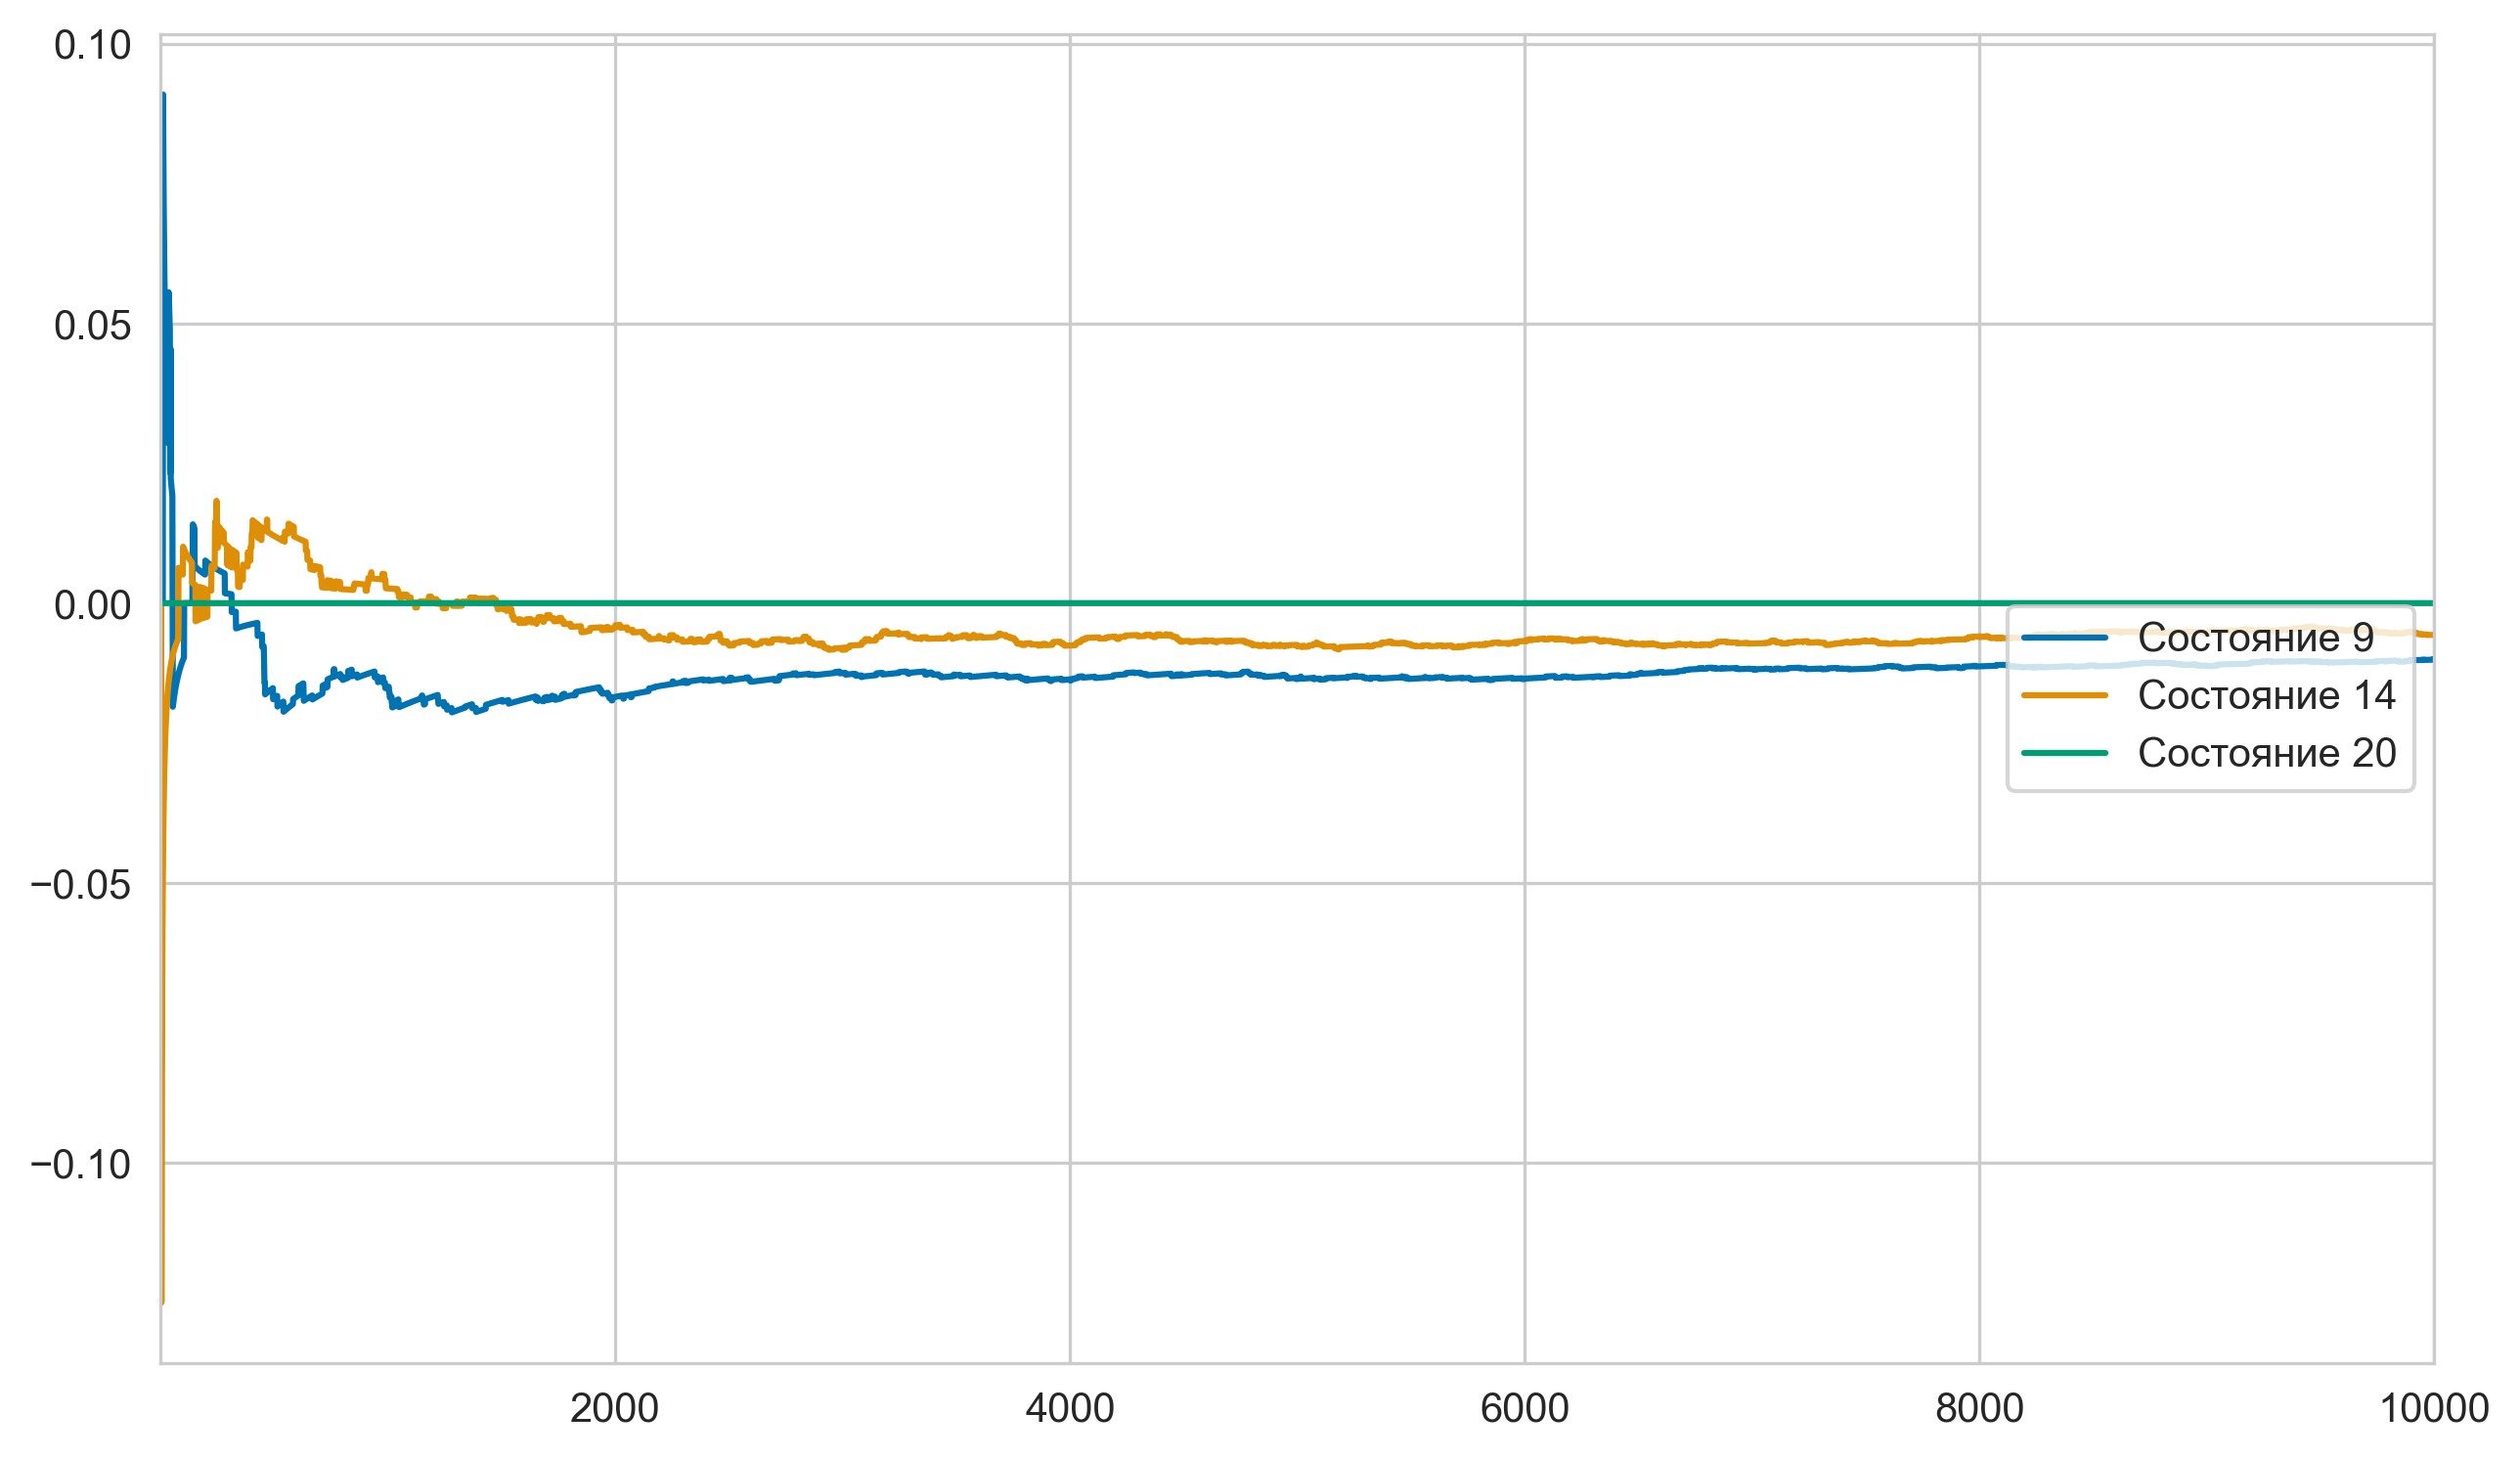

In [7]:
mean_returns = [np.true_divide( np.nancumsum(R_all[s]), np.arange(1, len(R_all[s])+1) ) for s in range(nS) ]

fig, ax = plt.subplots(1, 1, figsize=(10, 6))

for i,s in enumerate([9, 14, 20]):
    ax.plot(np.arange(1, len(R_all[s])+1), mean_returns[s], label="Состояние %d" % s, color="C%d" % i)

ax.legend(loc="center right")
ax.set_xlim((1, 10000))
# ax.set_ylim((0.1, 0.8))
# ax2.set_ylim((10, 45))

## Monte-Carlo control с on-policy исследованием

In [8]:
def compute_policy_by_Q(env, Q, gamma=1.0):
    return np.argmax( Q, axis=1 )

def update_returns_actions(R, states, actions, rewards, gamma=1.0, R_all=None):
    state_first_visit = [-1 for _ in range(nS)]
    for t, state in enumerate(states):
        if state_first_visit[state] == -1:
            state_first_visit[state] = t
    g = 0
    if R_all is not None:
        _ = [R_all[s][a].append(np.nan) for a in range(nA) for s in range(nS)]
    if state_first_visit[states[-1]] == len(states)-1:
        R[states[-1]][actions[-1]].append(g)
        if R_all is not None:
            R_all[states[t]][actions[t]][-1] = g
    for t in range(len(states)-2, -1, -1):
        g =  g * gamma + rewards[t+1]
        if state_first_visit[states[t]] == t:
            R[states[t]][actions[t]].append(g)
            if R_all is not None:
                R_all[states[t]][actions[t]][-1] = g
    return R, R_all

def get_Q_by_R(R, Q_default=None):
    Q = Q_default if Q_default is not None else np.zeros((nS, nA))
    for s in range(nS):
        for a in range(nA):
            if len(R[s][a]) > 0:
                Q[s][a] = np.mean(R[s][a])
    return Q

def run_episode_actions(env, pi, eps=0.0):
    state = env.reset()
    current_state = 22 if state[0] > 21 else state[0]
    next_action = pi[current_state] if np.random.rand() > eps else np.random.randint(nA)
    states, actions, rewards = [current_state], [next_action], [0]
    for _ in range(1000):
        observation, reward, done, info = env.step(next_action)
        current_state = 22 if observation[0] > 21 else observation[0]
        states.append(current_state)
        next_action = pi[current_state] if np.random.rand() > eps else np.random.randint(nA)
        actions.append(next_action)
        rewards.append(reward)
        if done:
            break
    return states, actions, rewards

In [9]:
nA = env.action_space.n
env._max_episode_steps = 10000
init_episodes, total_episodes = 100, 50000
gamma = 0.9

R, R_all = [[[] for _ in range(nA) ] for _ in range(nS) ], [[[] for _ in range(nA)] for _ in range(nS)]
Q = get_random_Q(env)
pi = compute_policy_by_Q(env, Q)

for _ in range(init_episodes):
    states, actions, rewards = run_episode_actions(env, pi, eps=0.1)
    R, R_all = update_returns_actions(R, states, actions, rewards, gamma=gamma, R_all=R_all)

for _ in range(total_episodes):
    states, actions, rewards = run_episode_actions(env, pi, eps=0.1)
    R, R_all = update_returns_actions(R, states, actions, rewards, gamma=gamma, R_all=R_all)
    Q = get_Q_by_R(R, Q_default=Q)
    pi = compute_policy_by_Q(env, Q)


In [10]:
def get_mean_returns(R_all):
    mean_returns = [[[] for _ in range(nA)] for _ in range(nS)]
    for s in range(nS):
        for a in range(nA):
            cur_denominator, cur_value = 0., 0.
            for r in R_all[s][a]:
                if not np.isnan(r):
                    cur_denominator += 1.
                    cur_value += r
                mean_returns[s][a].append(cur_value / cur_denominator if cur_denominator > 0 else 0)
    return mean_returns
                
mean_returns = get_mean_returns(R_all)

Text(0, 0.5, 'Текущая оценка')

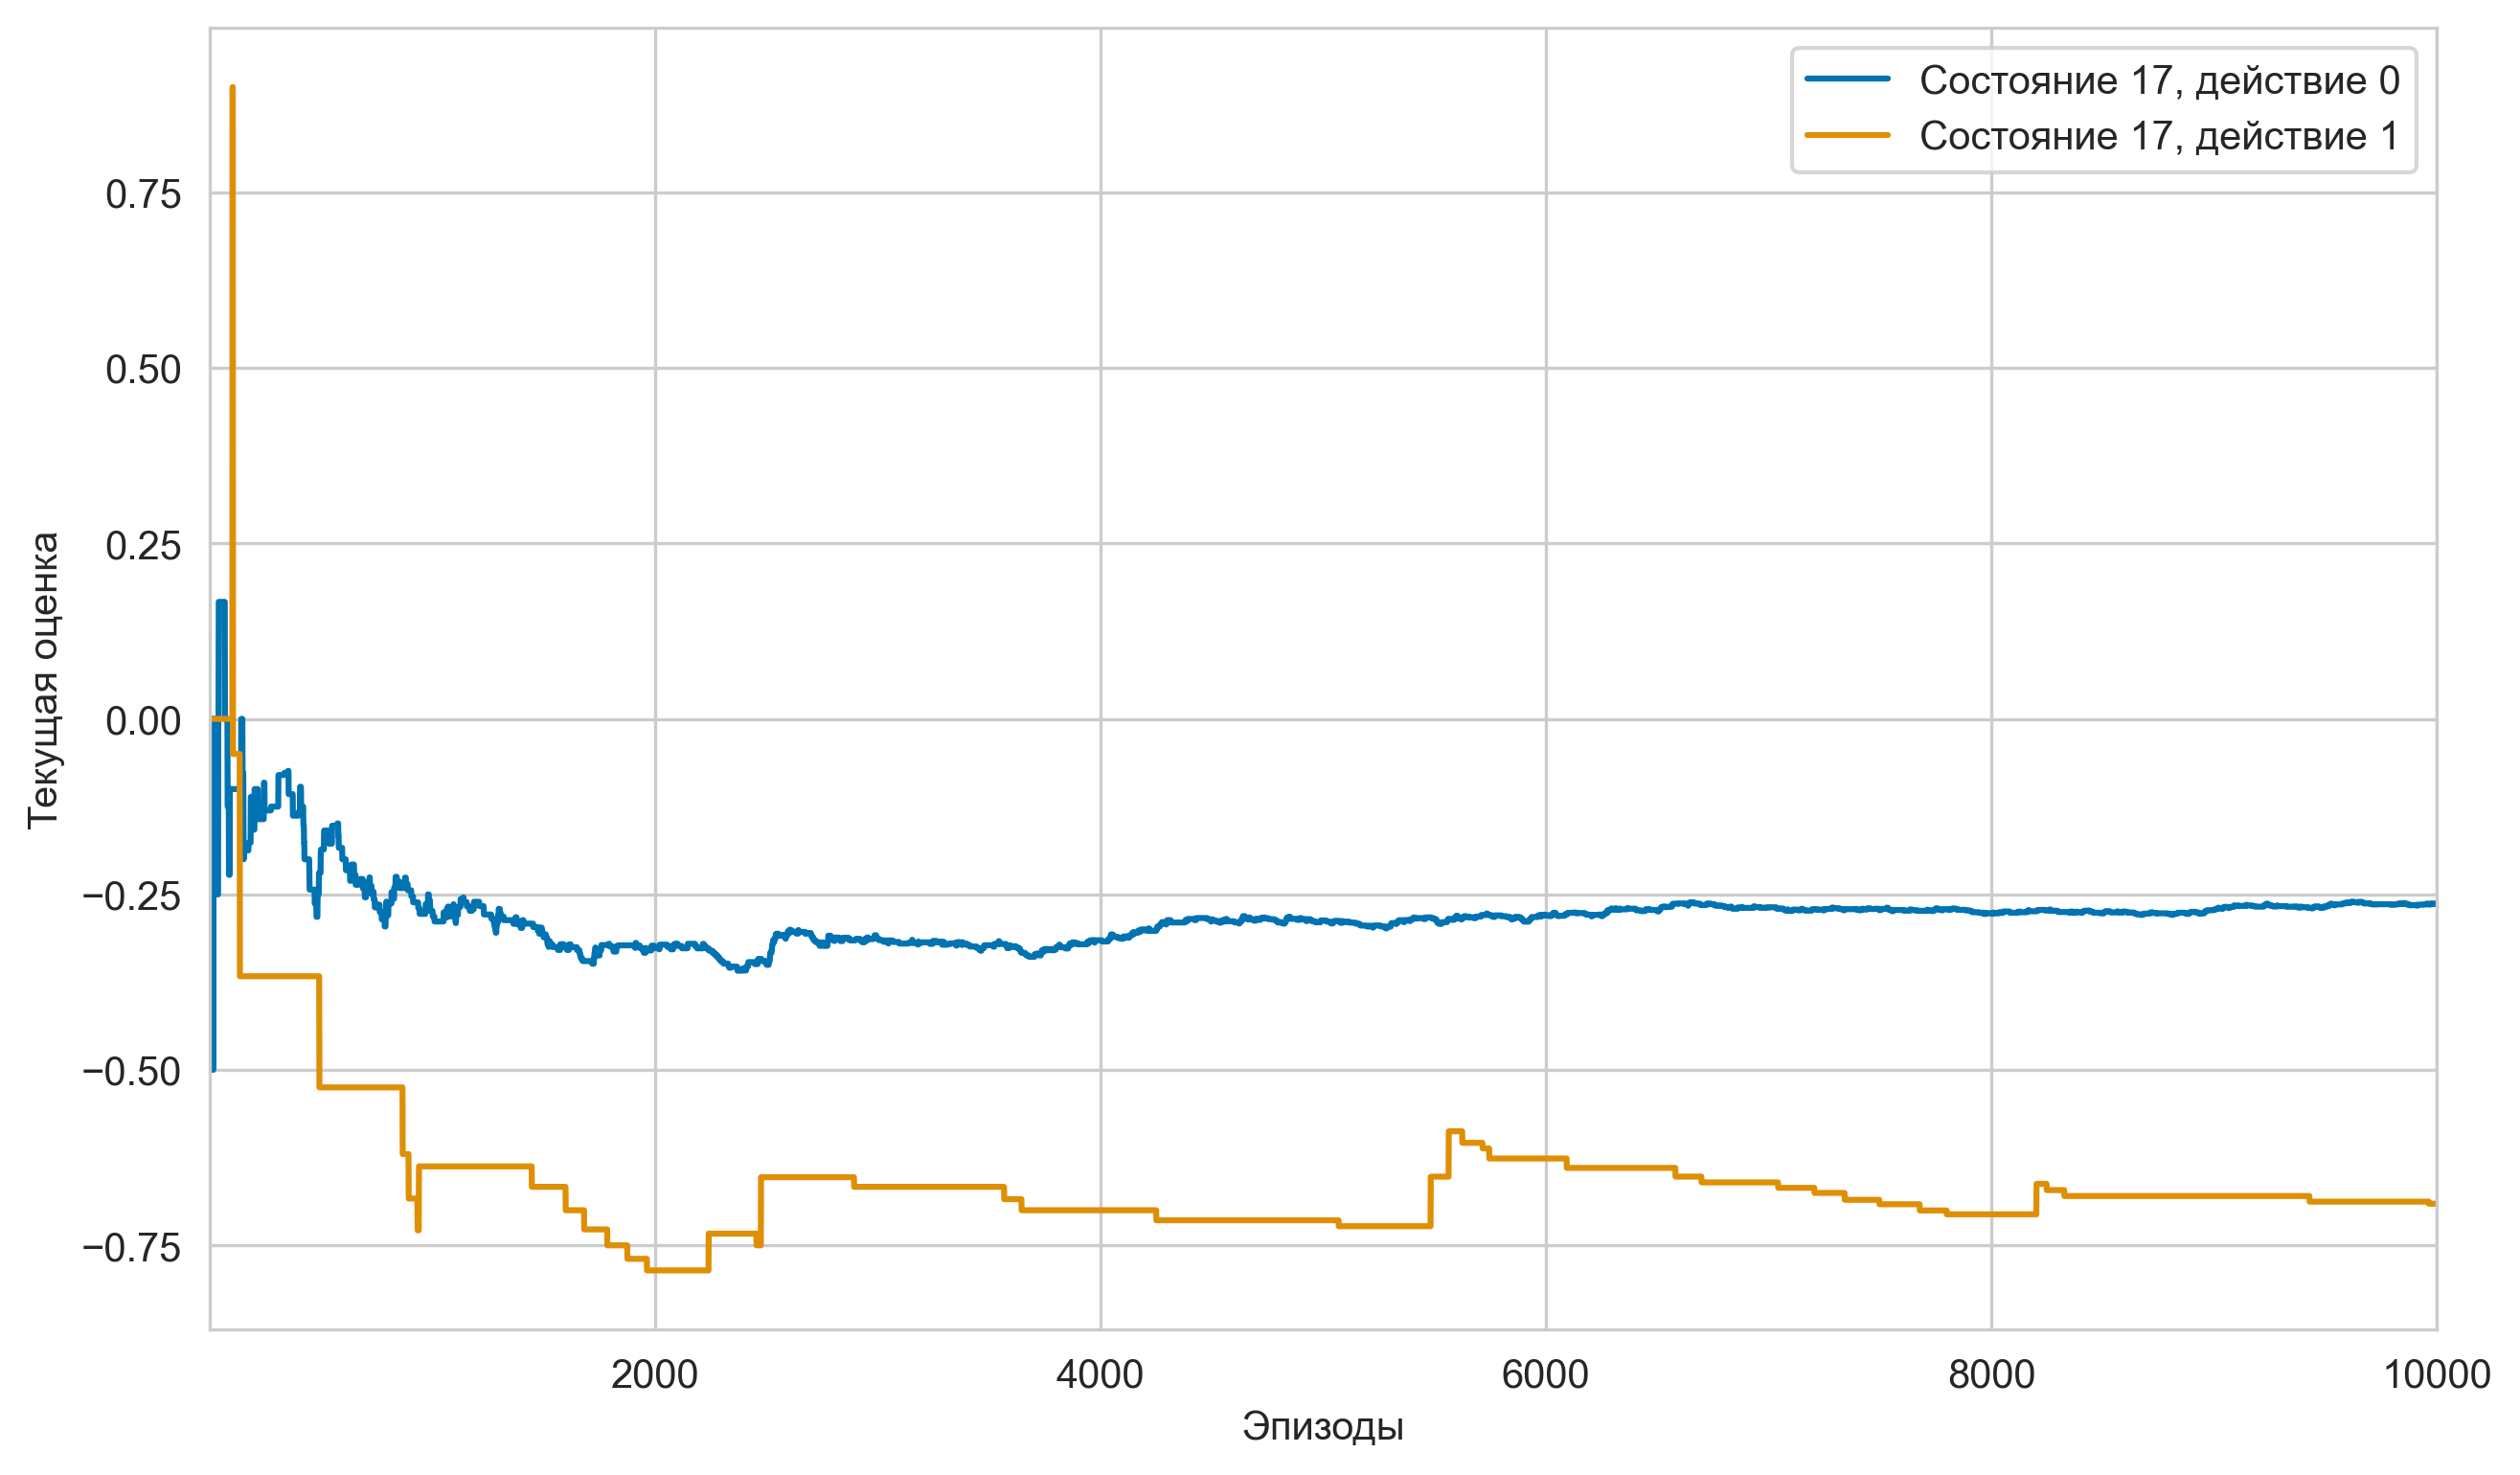

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
ss = 17
for i,s_a in enumerate([(ss,0), (ss,1)]):
        s,a = s_a
        ax.plot(np.arange(1, len(R_all[s][a])+1), mean_returns[s][a], label="Состояние %d, действие %d" % (s, a), color="C%d" % i)

ax.legend(loc="upper right")
ax.set_xlim((1, 10000))
ax.set_xlabel("Эпизоды")
ax.set_ylabel("Текущая оценка")

In [12]:
num_experiments = 10000
num_steps, total_reward = [], []
eps = 0.0
for _ in range(num_experiments):
    state = env.reset()
    total_reward.append(0)
    for step in range(1000):
        current_state = 22 if state[0] > 21 else state[0]
        next_action = pi[current_state] if np.random.rand() > eps else np.random.randint(nA)
        state, reward, done, info = env.step(next_action)
        total_reward[-1] += reward
        if done:
            num_steps.append(step+1)
            break
env.close()

print("\nСредняя награда: %.6f\nСреднее число шагов: %.6f" % (np.mean(total_reward), np.mean(num_steps)))


Средняя награда: -0.092000
Среднее число шагов: 1.446500


## Monte-Carlo control с off-policy исследованием

In [13]:
def update_lists(s, a, g, w, Q, C, Q_all):
    C[s][a] = C[s][a] + w
    Q[s][a] = Q[s][a] + (g - Q[s][a]) * w / C[s][a]
    if Q_all is not None:
        Q_all[s][a][-1] = g


def update_returns_actions_offpolicy_MC(Q, C, pi, states, actions, rewards, epsilon=0.1, gamma=1.0, Q_all=None):
    g, w, prob_best_action = 0., 1., 1 - (nA-1) * epsilon / nA
    if Q_all is not None:
        _ = [Q_all[s][a].append(np.nan) for a in range(nA) for s in range(nS)]

    # Обновляем функции для последнего хода
    update_lists(states[-1], actions[-1], g, w, Q, C, Q_all)
    
    for t in range(len(states)-2, -1, -1):
        # Если действие не соответствует лучшей стратегии, дальше не надо смотреть
        if actions[t+1] != pi[states[t+1]]:
            break
            
        # Обновляем веса и return
        w = w / ( prob_best_action )
        g =  g * gamma + rewards[t+1]
        
        # Обновляем функции
        update_lists(states[t], actions[t], g, w, Q, C, Q_all)
    return Q, C, Q_all

In [14]:
Q_all = [ [ [] for _ in range(nA) ] for _ in range(nS) ]

Q = get_random_Q(env)
pi = compute_policy_by_Q(env, Q)
C = np.zeros((nS, nA), dtype=float)

for _ in range(total_episodes):
    states, actions, rewards = run_episode_actions(env, pi, eps=0.1)
    Q, C, Q_all = update_returns_actions_offpolicy_MC(Q, C, pi, states, actions, rewards, gamma=gamma, Q_all=Q_all)
    pi = compute_policy_by_Q(env, Q)

In [15]:
mean_returns = get_mean_returns(Q_all)

Text(0, 0.5, 'Текущая оценка')

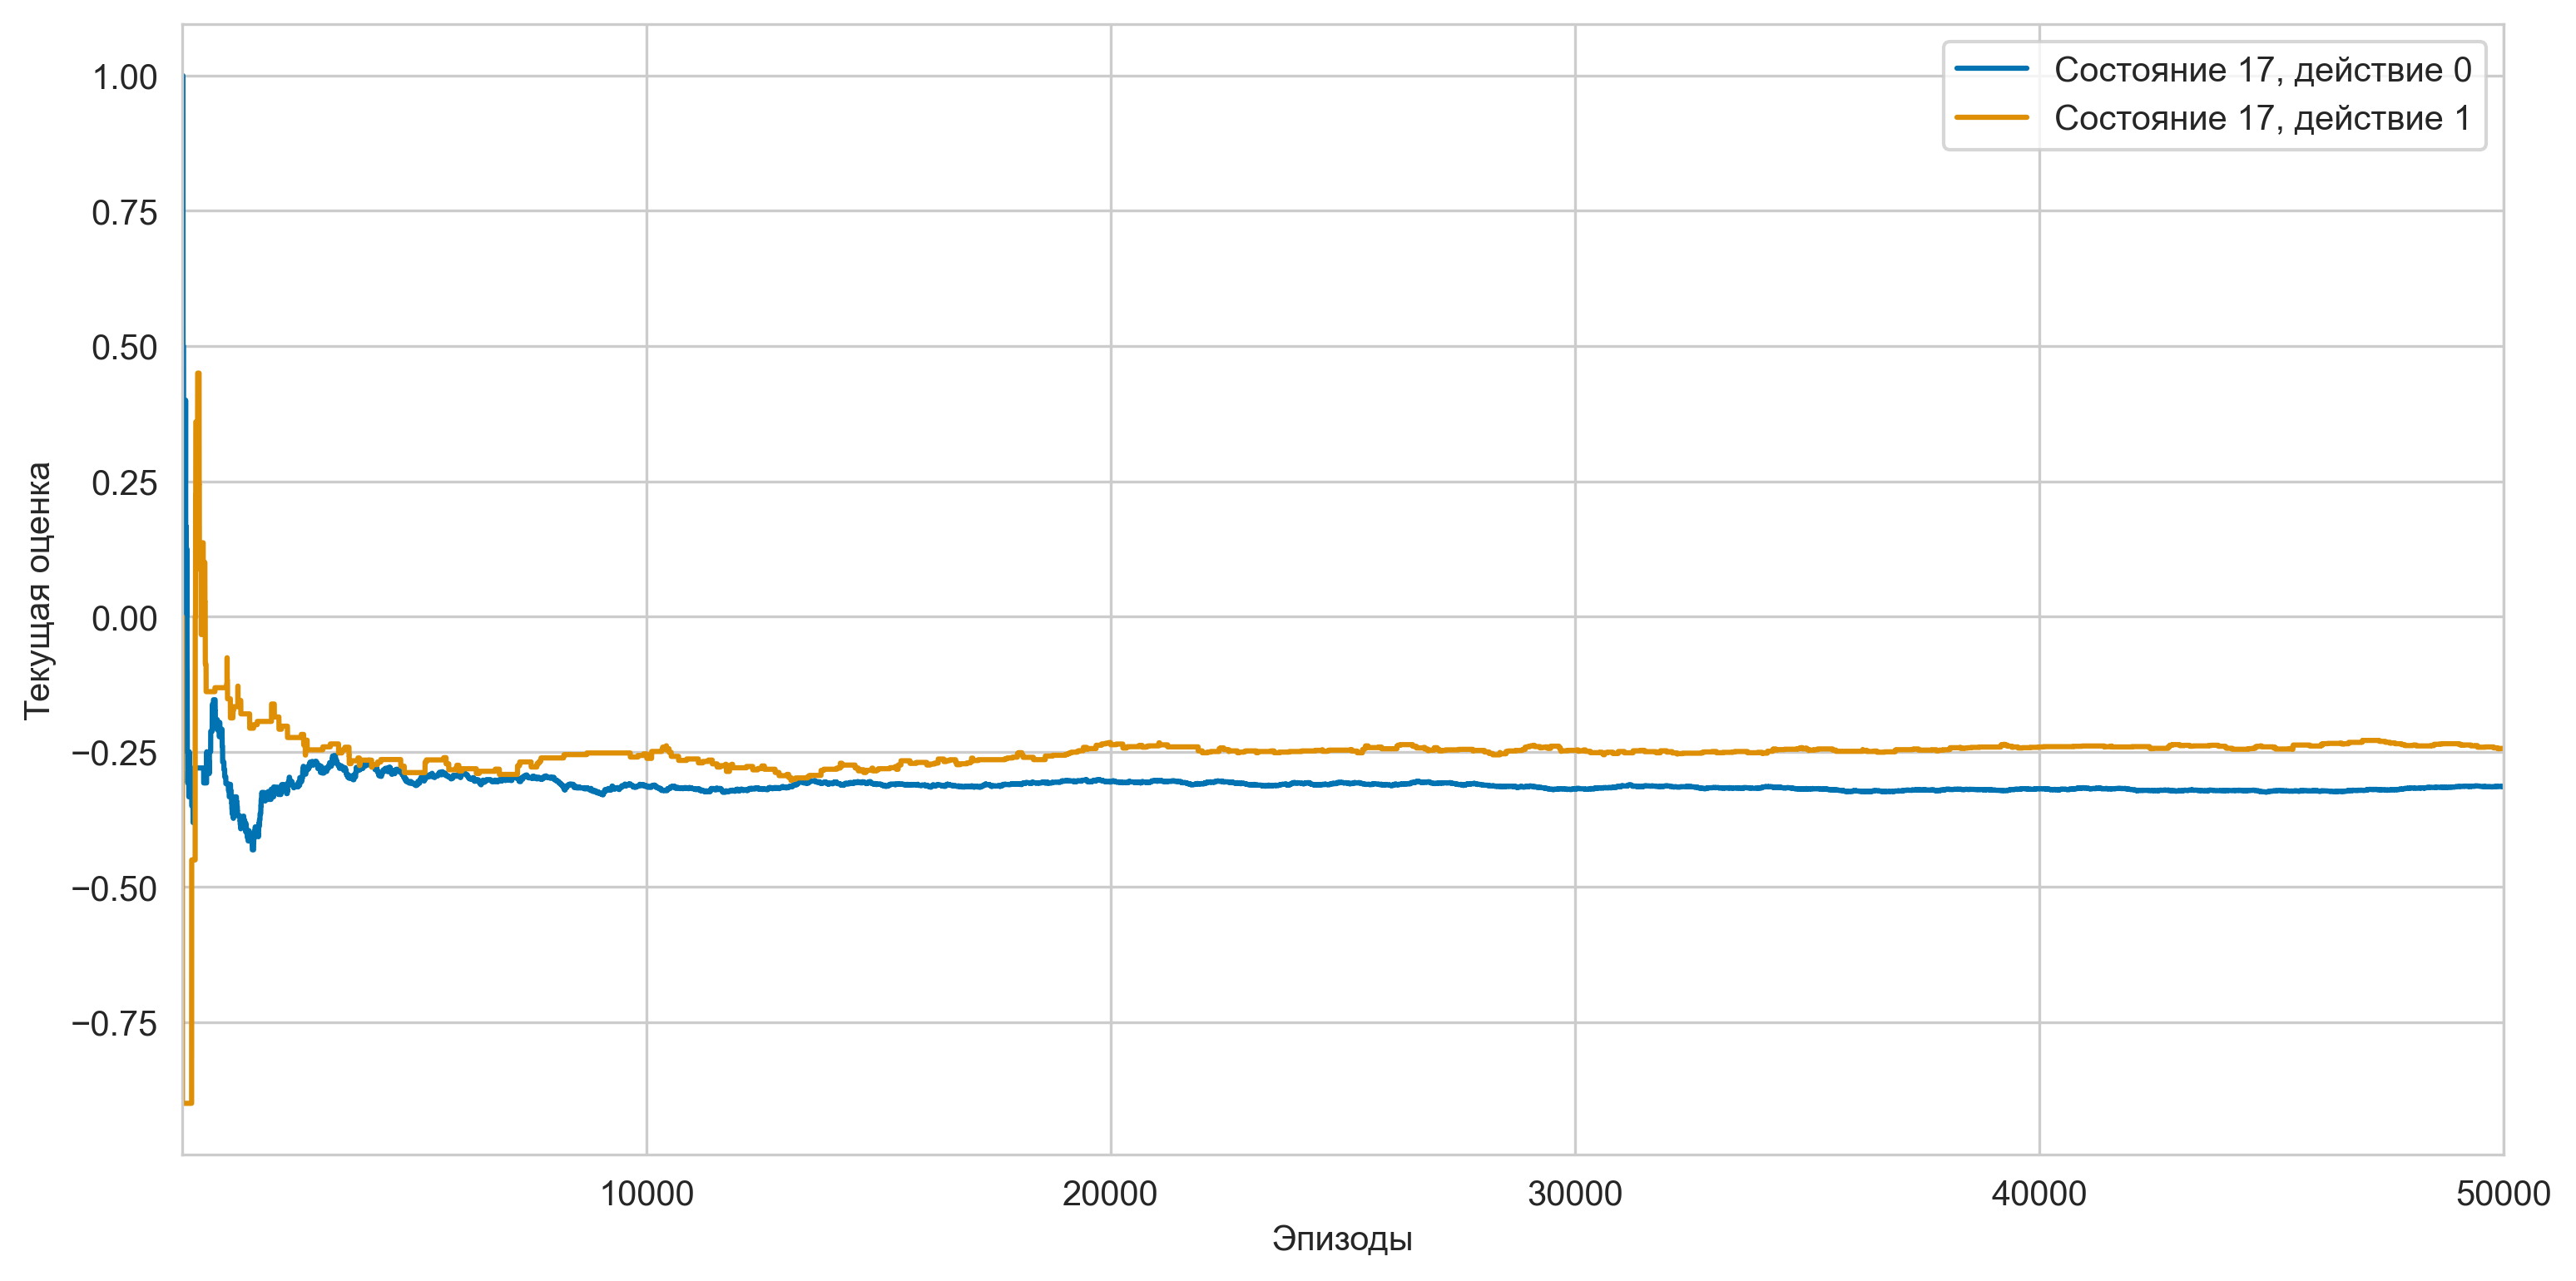

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))

ss = 17
for i,s_a in enumerate([(ss,0), (ss,1)]):
    s,a = s_a
    ax.plot(np.arange(1, len(Q_all[s][a])+1), mean_returns[s][a], label="Состояние %d, действие %d" % (s, a), color="C%d" % i)

ax.legend(loc="upper right")
ax.set_xlim((1, 50000))
ax.set_xlabel("Эпизоды")
ax.set_ylabel("Текущая оценка")

In [17]:
num_experiments = 10000
num_steps, total_reward = [], []
eps = 0.1
for _ in range(num_experiments):
    state = env.reset()
    total_reward.append(0)
    for step in range(1000):
        current_state = 22 if state[0] > 21 else state[0]
        next_action = pi[current_state] if np.random.rand() > eps else np.random.randint(nA)
        state, reward, done, info = env.step(next_action)
        total_reward[-1] += reward
        if done:
            num_steps.append(step+1)
            break
print("\nСредняя награда: %.6f\nСреднее число шагов: %.6f" % (np.mean(total_reward), np.mean(num_steps)))


Средняя награда: -0.132800
Среднее число шагов: 1.236000


## TD-обучение: off-policy (Q-обучение)

In [18]:
def Q_learning_episode(env, pi, Q, alpha=0.05, epsilon=0.0, gamma=0.9):
    state = env.reset()
    current_state = state[0]
    s, a = current_state, pi[current_state] if np.random.rand() > epsilon else np.random.randint(nA)
    for _ in range(1000):
        observation, reward, done, info = env.step(a)
        current_state = 22 if observation[0] > 21 else observation[0]
        s_prime, a_prime = current_state, pi[current_state] if np.random.rand() > epsilon else np.random.randint(nA)
        Q[s][a] = Q[s][a] + alpha * (reward + gamma * np.max( Q[s_prime] ) - Q[s][a])
        s, a = s_prime, a_prime
        if done:
            break

In [19]:
env._max_episode_steps = 10000
total_episodes = 50000
gamma = 0.9

Q_hist_Qlearn = [ ]

Q = get_random_Q(env)
pi = compute_policy_by_Q(env, Q)

for n in range(total_episodes):
    Q_learning_episode(env, pi, Q, alpha=0.05, epsilon= 0.1, gamma=gamma)
    pi = compute_policy_by_Q(env, Q)
    Q_hist_Qlearn.append(np.copy(Q))

env.close()

Text(0, 0.5, 'Текущая оценка')

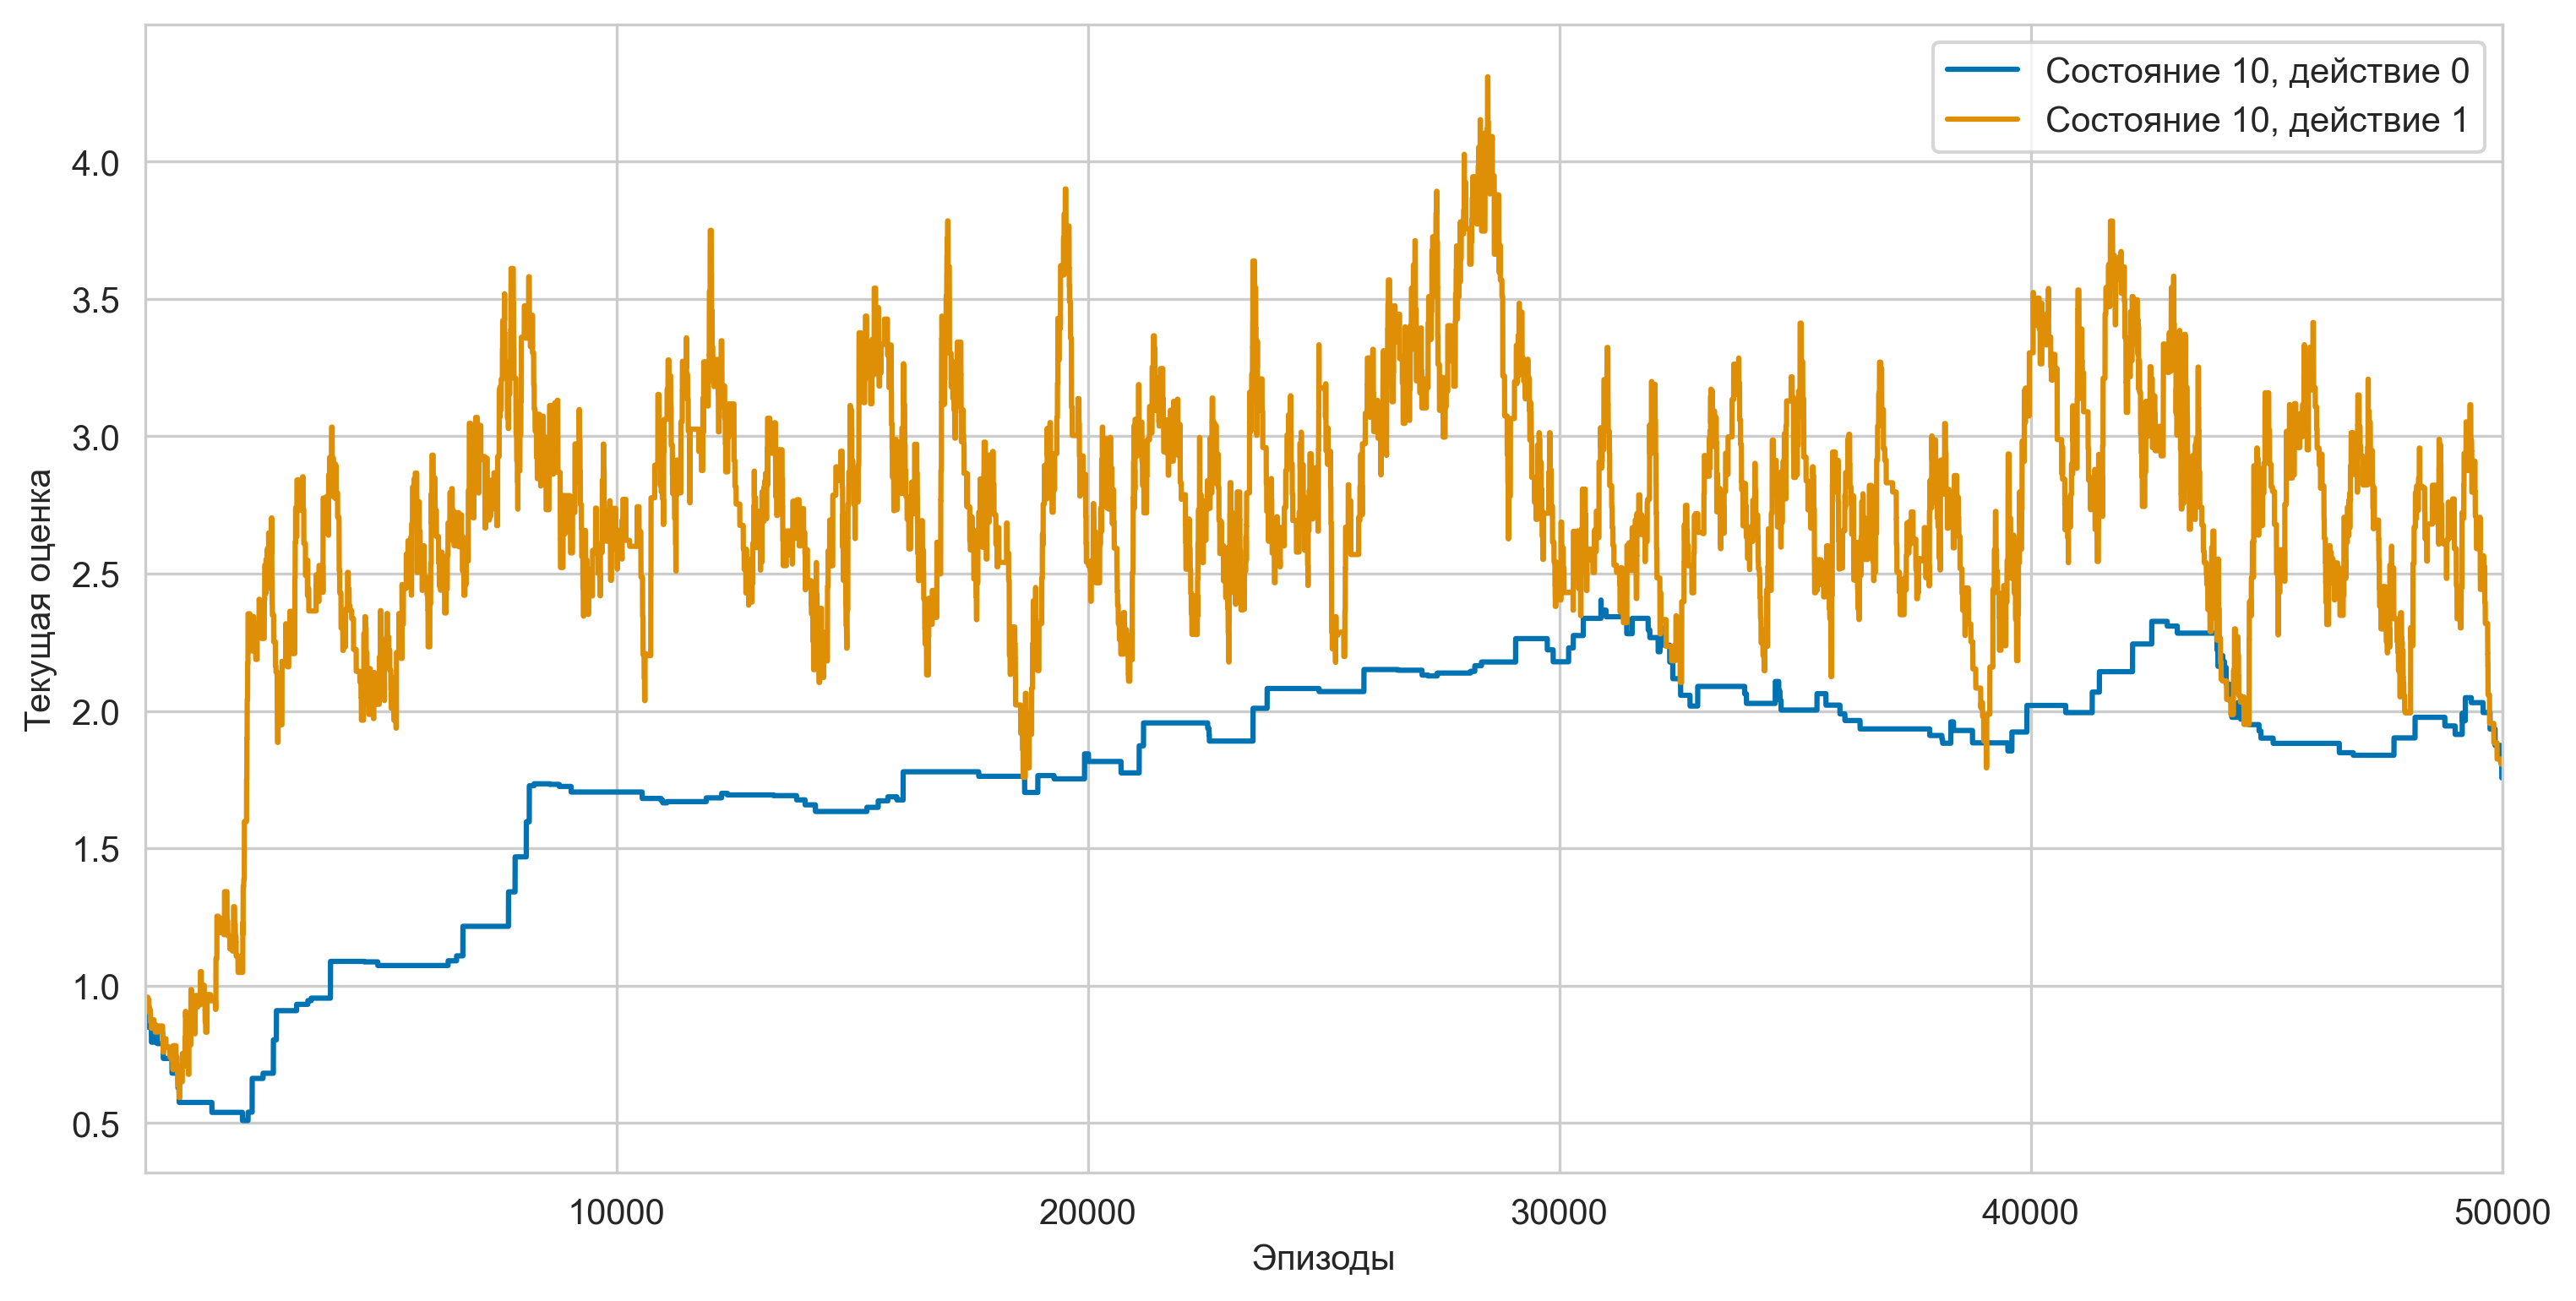

In [20]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))

ss = 10
for i,s_a in enumerate([(ss,0), (ss,1)]):
    s,a = s_a
    ax.plot(np.arange(1, total_episodes+1), [q[s][a] for q in Q_hist_Qlearn], label="Состояние %d, действие %d" % (s, a), color="C%d" % i)

ax.legend(loc="upper right")
ax.set_xlim((1, total_episodes))
ax.set_xlabel("Эпизоды")
ax.set_ylabel("Текущая оценка")
# ax.set_ylim((0, 0.2))

In [21]:
num_experiments = 10000
num_steps, total_reward = [], []
eps = 0.0
for _ in range(num_experiments):
    state = env.reset()
    total_reward.append(0)
    for step in range(1000):
        current_state = 22 if state[0] > 21 else state[0]
        next_action = pi[current_state] if np.random.rand() > eps else np.random.randint(nA)
        state, reward, done, info = env.step(next_action)
        total_reward[-1] += reward
        if done:
            num_steps.append(step+1)
            break
env.close()

print("\nСредняя награда: %.6f\nСреднее число шагов: %.6f" % (np.mean(total_reward), np.mean(num_steps)))


Средняя награда: -0.113100
Среднее число шагов: 1.685400


In [22]:
def conduct_experiments_pi(env, pi, num_experiments=1000):
    num_steps, total_reward = [], []
    for _ in range(num_experiments):
        state = env.reset()
        num_steps.append(0)
        total_reward.append(0)
        for _ in range(1000):
            current_state = 22 if state[0] > 21 else state[0]
            next_action = pi[current_state]
            state, reward, done, info = env.step(next_action)
            total_reward[-1] += reward
            num_steps[-1] += 1
            if done:
                break
    env.close()
    return np.mean(total_reward), np.mean(num_steps)

def conduct_experiments(env, gamma=1.0, num_experiments=100, num_experiments_pi=10):
    num_steps, total_reward = [], []
    for _ in range(num_experiments):
        V, pi = compute_V_and_pi(env, gamma=gamma)
        cur_steps, cur_reward = conduct_experiments_pi(env, pi, num_experiments=num_experiments_pi)
        num_steps.append(cur_steps)
        total_reward.append(cur_reward)
    return np.mean(num_steps), np.mean(total_reward)

In [23]:
env._max_episode_steps = 100

num_experiments, num_experiments_pi = 100, 10000

total_episodes = 1500
gamma = 0.9
k = []
results_Qlearn = []

Q_arr = [ get_random_Q(env) for _ in range(num_experiments) ]
pi_arr = [ compute_policy_by_Q(env, Q) for Q in Q_arr ]

for n in range(total_episodes):
    _ = [ Q_learning_episode(env, pi_arr[i], Q_arr[i], alpha=0.1, epsilon= .1 , gamma=gamma) for i in range(num_experiments) ]
    pi_arr = [ compute_policy_by_Q(env, Q) for Q in Q_arr ]
    if (n % 100 == 0):
        k.append(n)
        result = [ conduct_experiments_pi(env, pi, num_experiments=num_experiments_pi) for pi in pi_arr ]
        results_Qlearn.append([ [x[0], x[1]] for x in result ])

Text(0.5, 0, 'Эпизоды')

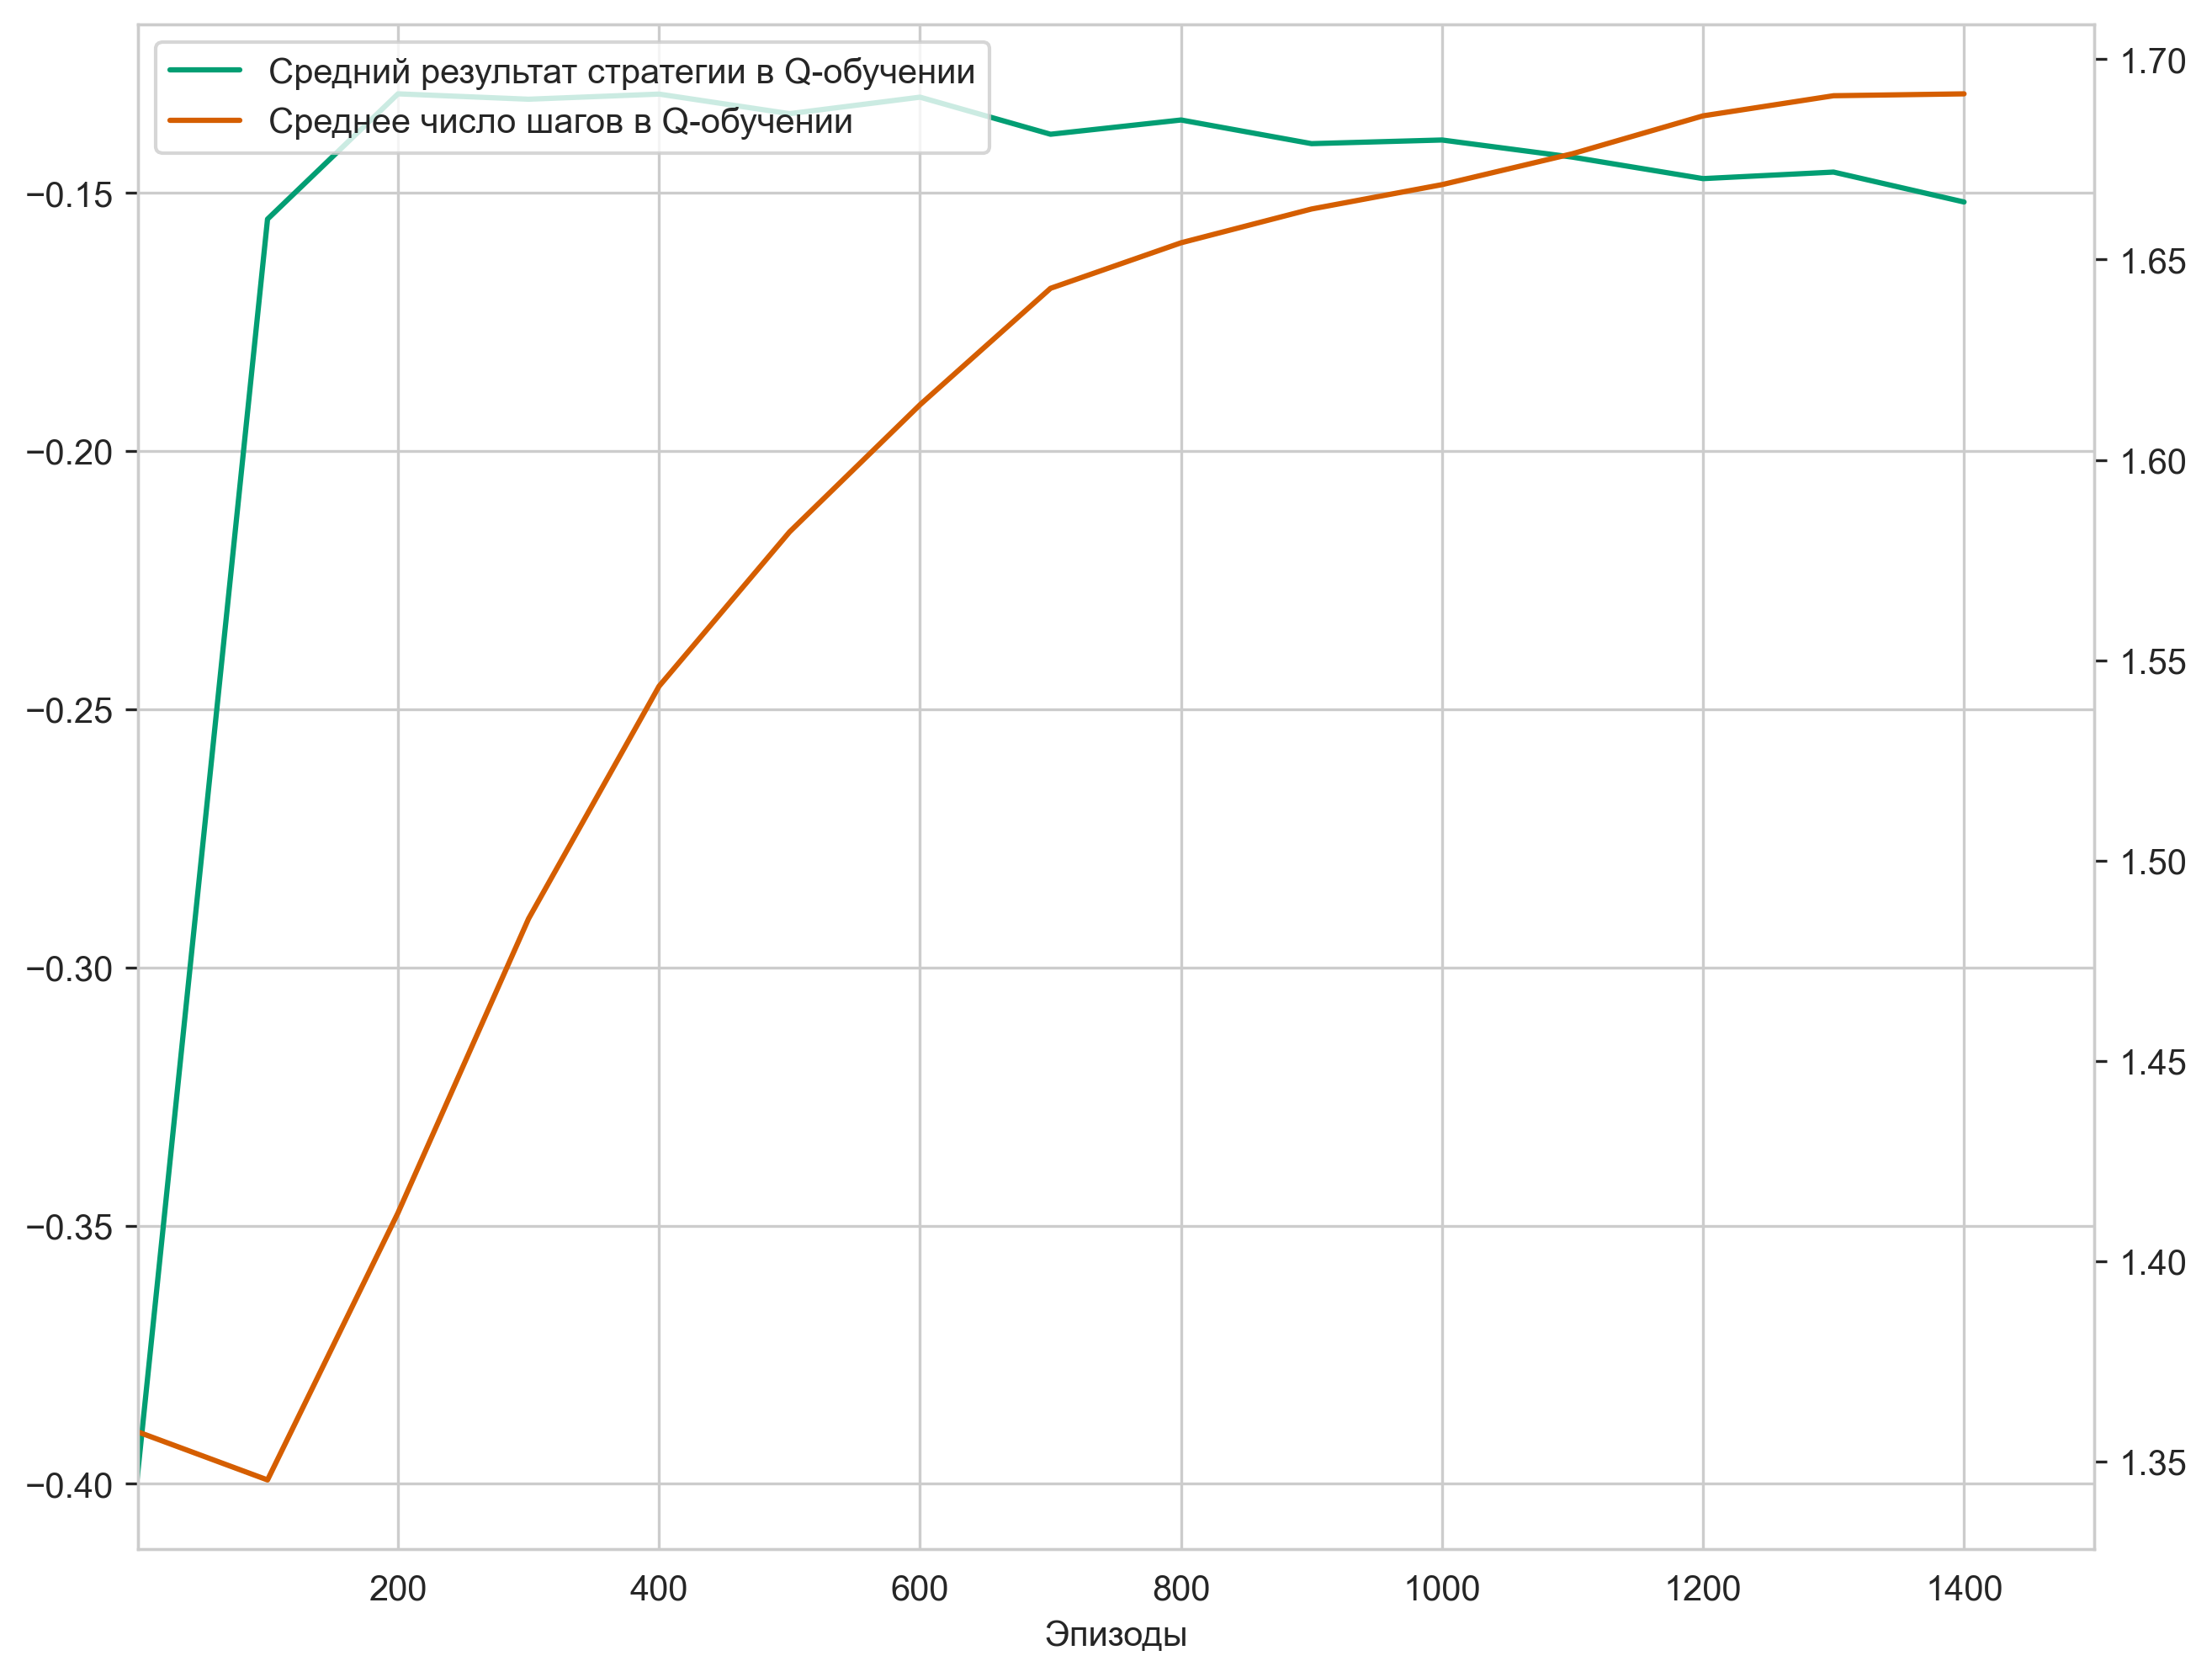

In [24]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
ax2 = ax.twinx()
ax2.grid(None)

avg_returns_Q = np.mean( np.array([ [x[0] for x in res] for res in results_Qlearn]), axis=1)
avg_steps_Q = np.mean( np.array([ [x[1] for x in res] for res in results_Qlearn]), axis=1)

line1 = ax.plot(k, avg_returns_Q, label="Средний результат стратегии в Q-обучении", color="C2")
line2 = ax2.plot(k, avg_steps_Q, label="Среднее число шагов в Q-обучении", color="C3")

lines = line1 + line2
labels = [l.get_label() for l in lines]
ax.legend(lines, labels, loc="upper left")
# ax.set_xlim((0.5, 1.0))
ax.set_xlim((1, total_episodes))
ax.set_xlabel("Эпизоды")

## Добавим удвоение ставки

In [25]:
from gym import spaces
from gym.utils import seeding

def cmp(a, b):
    return float(a > b) - float(a < b)

# 1 = Ace, 2-10 = Number cards, Jack/Queen/King = 10
deck = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 10, 10]


def draw_card(np_random):
    return int(np_random.choice(deck))


def draw_hand(np_random):
    return [draw_card(np_random), draw_card(np_random)]


def usable_ace(hand):  # Does this hand have a usable ace?
    return 1 in hand and sum(hand) + 10 <= 21


def sum_hand(hand):  # Return current hand total
    if usable_ace(hand):
        return sum(hand) + 10
    return sum(hand)


def is_bust(hand):  # Is this hand a bust?
    return sum_hand(hand) > 21


def score(hand):  # What is the score of this hand (0 if bust)
    return 0 if is_bust(hand) else sum_hand(hand)


def is_natural(hand):  # Is this hand a natural blackjack?
    return sorted(hand) == [1, 10]


class DoubleBlackjack(gym.Env):
    
    def __init__(self, natural=False):
        self.action_space = spaces.Discrete(3)
        self.observation_space = spaces.Tuple((
            spaces.Discrete(32),
            spaces.Discrete(11),
            spaces.Discrete(2)))
        self.seed()

        # Flag to payout 1.5 on a "natural" blackjack win, like casino rules
        # Ref: http://www.bicyclecards.com/how-to-play/blackjack/
        self.natural = natural
        # Start the first game
        self.reset()

    def seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    def step(self, action):
        assert self.action_space.contains(action)
        if action == 2: # double down: bet double and get only 1 card
                self.player.append(draw_card(self.np_random))
                done = True
                if is_bust(self.player):
                    reward = -2
                else: 
                    while sum_hand(self.dealer) < 17:
                        self.dealer.append(draw_card(self.np_random))
                    reward = 2 * cmp(score(self.player), score(self.dealer))
        if action == 1:  # hit: add a card to players hand and return
            self.player.append(draw_card(self.np_random))
            if is_bust(self.player):
                done = True
                reward = -1.
            else:
                done = False
                reward = 0.
        else:  # stick: play out the dealers hand, and score
            done = True
            while sum_hand(self.dealer) < 17:
                self.dealer.append(draw_card(self.np_random))
            reward = cmp(score(self.player), score(self.dealer))
            if self.natural and is_natural(self.player) and reward == 1.:
                reward = 1.5
        return self._get_obs(), reward, done, {}

    def _get_obs(self):
        return (sum_hand(self.player), self.dealer[0], usable_ace(self.player))

    def reset(self):
        self.dealer = draw_hand(self.np_random)
        self.player = draw_hand(self.np_random)
        return self._get_obs()


In [26]:
env2 = DoubleBlackjack()
env2.reset()

(21, 5, True)

In [27]:
nA = env2.action_space.n

env2._max_episode_steps = 10000
total_episodes = 50000
gamma = 0.01

Q_hist_Qlearn = [ ]

Q = get_random_Q(env2)
pi = compute_policy_by_Q(env2, Q)

for n in range(total_episodes):
    Q_learning_episode(env2, pi, Q, alpha=0.05, epsilon=0.9, gamma=gamma)
    pi = compute_policy_by_Q(env2, Q)
    Q_hist_Qlearn.append(np.copy(Q))



In [28]:
num_experiments = 10000
num_steps, total_reward = [], []
eps = 0.0
for _ in range(num_experiments):
    state = env2.reset()
    total_reward.append(0)
    for step in range(1000):
        current_state = 22 if state[0] > 21 else state[0]
        next_action = pi[current_state] if np.random.rand() > eps else np.random.randint(nA)
        state, reward, done, info = env2.step(next_action)
        total_reward[-1] += reward
        if done:
            num_steps.append(step+1)
            break
print("\nСредняя награда: %.6f\nСреднее число шагов: %.6f" % (np.mean(total_reward), np.mean(num_steps)))


Средняя награда: -0.057800
Среднее число шагов: 1.393600


In [29]:
# Протестируем, как хорошо работают стратегии и как быстро учатся
env._max_episode_steps = 100

num_experiments, num_experiments_pi = 100, 10000

total_episodes = 1500
gamma = 0.8

results_Qlearn = []

Q_arr = [ get_random_Q(env2) for _ in range(num_experiments) ]
pi_arr = [ compute_policy_by_Q(env2, Q) for Q in Q_arr ]
k = []
for n in range(1, total_episodes+1, ):
    _ = [ Q_learning_episode(env2, pi_arr[i], Q_arr[i], alpha=0.1, epsilon= .1 , gamma=gamma) for i in range(num_experiments) ]
    pi_arr = [ compute_policy_by_Q(env2, Q) for Q in Q_arr ]
    if (n % 100 == 0):
        k.append(n)
        result = [ conduct_experiments_pi(env2, pi, num_experiments=num_experiments_pi) for pi in pi_arr ]
        results_Qlearn.append([ [x[0], x[1]] for x in result ])

Text(0.5, 0, 'Эпизоды')

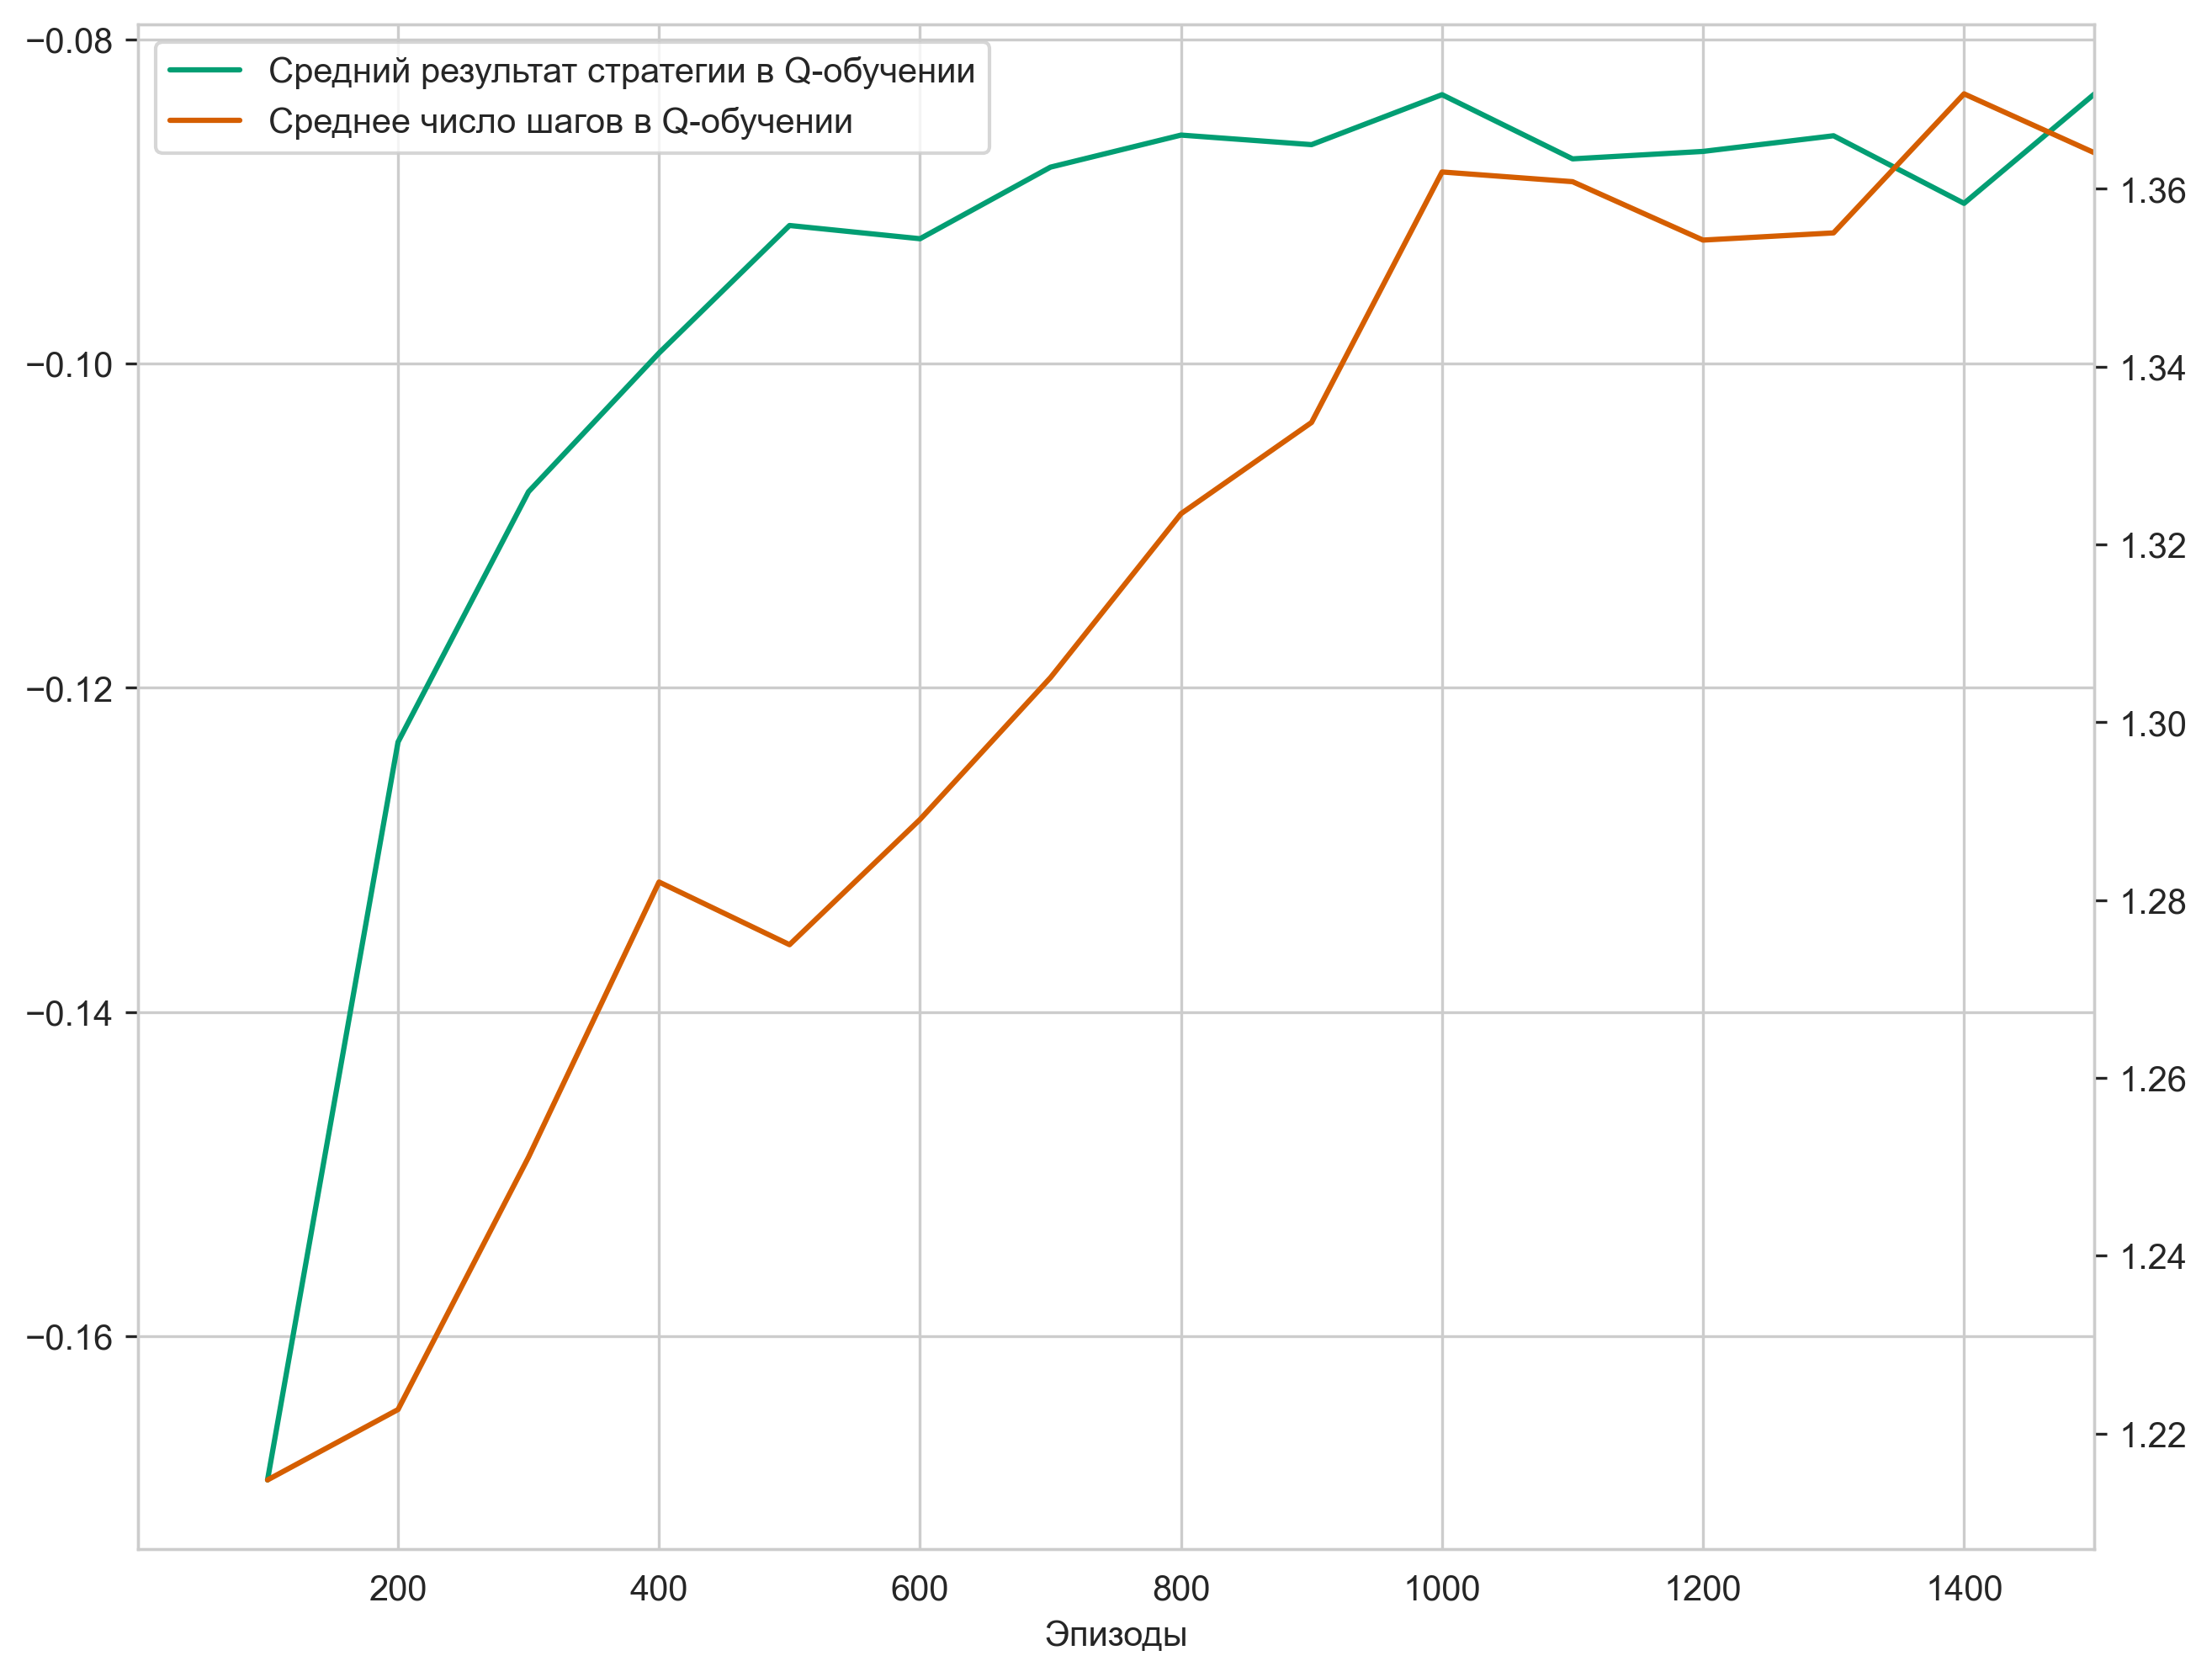

In [30]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
ax2 = ax.twinx()
ax2.grid(None)

avg_returns_Q = np.mean( np.array([ [x[0] for x in res] for res in results_Qlearn]), axis=1)
avg_steps_Q = np.mean( np.array([ [x[1] for x in res] for res in results_Qlearn]), axis=1)

line1 = ax.plot(k, avg_returns_Q, label="Средний результат стратегии в Q-обучении", color="C2")
line2 = ax2.plot(k, avg_steps_Q, label="Среднее число шагов в Q-обучении", color="C3")

lines = line1 + line2
labels = [l.get_label() for l in lines]
ax.legend(lines, labels, loc="upper left")
# ax.set_xlim((0.5, 1.0))
ax.set_xlim((1, total_episodes))
ax.set_xlabel("Эпизоды")

## Попробуем сыграть в natural blackjack

In [31]:
env2 = DoubleBlackjack(natural = True)
env2.reset()

(18, 10, False)

In [32]:
Q_all = [ [ [] for _ in range(nA) ] for _ in range(nS) ]
total_episodes = 10000

Q = get_random_Q(env2)
pi = compute_policy_by_Q(env2, Q)
C = np.zeros((nS, nA), dtype=float)

for _ in range(total_episodes):
    states, actions, rewards = run_episode_actions(env2, pi, eps=0.1)
    Q, C, Q_all = update_returns_actions_offpolicy_MC(Q, C, pi, states, actions, rewards, gamma=gamma, Q_all=Q_all)
    pi = compute_policy_by_Q(env2, Q)

env2.close()

In [33]:
num_experiments = 10000
num_steps, total_reward = [], []
eps = 0.0
for _ in range(num_experiments):
    state = env2.reset()
    total_reward.append(0)
    for step in range(1000):
        current_state = 22 if state[0] > 21 else state[0]
        next_action = pi[current_state] if np.random.rand() > eps else np.random.randint(nA)
        state, reward, done, info = env2.step(next_action)
        total_reward[-1] += reward
        if done:
            num_steps.append(step+1)
            break
print("\nСредняя награда: %.6f\nСреднее число шагов: %.6f" % (np.mean(total_reward), np.mean(num_steps)))


Средняя награда: -0.033600
Среднее число шагов: 1.253200


Забегая вперед, скажу, что это самый лучший минимальный проигрыш, которого удалось добиться.

## Добавим подсчет карт

In [34]:
summ_cards = 0

def cmp(a, b):
    return float(a > b) - float(a < b)

# 1 = Ace, 2-10 = Number cards, Jack/Queen/King = 10
deck2 = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 10, 10,
       1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 10, 10,
       1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 10, 10,
       1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 10, 10]

current_deck = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 10, 10,
       1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 10, 10,
       1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 10, 10,
       1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 10, 10]

def shuffle_cards():
    global current_deck, deck2, summ_cards
    current_deck = deck2.copy()
    summ_cards = 0


def card_reward(i):
    if i in [2, 3, 4, 5, 6]:
        return 1
    if i in [1, 10]:
        return -1
    return 0

def draw_card2(np_random):
    global current_deck
    if len(current_deck) <= 15:
        shuffle_cards()
    card_num = int(len(current_deck) * np.random.random())
    card = current_deck.pop(card_num)
    global summ_cards
    summ_cards = summ_cards + card_reward(card)
    return card


def draw_hand(np_random):
    return [draw_card2(np_random), draw_card2(np_random)]


def usable_ace(hand):  # Does this hand have a usable ace?
    return 1 in hand and sum(hand) + 10 <= 21


def sum_hand(hand):  # Return current hand total
    if usable_ace(hand):
        return sum(hand) + 10
    return sum(hand)


def is_bust(hand):  # Is this hand a bust?
    return sum_hand(hand) > 21


def score(hand):  # What is the score of this hand (0 if bust)
    return 0 if is_bust(hand) else sum_hand(hand)


def is_natural(hand):  # Is this hand a natural blackjack?
    return sorted(hand) == [1, 10]


class DeckDoubleBlackjack(gym.Env):
    
    def __init__(self, natural=False):
        self.action_space = spaces.Discrete(3)
        self.observation_space = spaces.Tuple((
            spaces.Discrete(32),
            spaces.Discrete(11),
            spaces.Discrete(2)))
        self.seed()

        # Flag to payout 1.5 on a "natural" blackjack win, like casino rules
        # Ref: http://www.bicyclecards.com/how-to-play/blackjack/
        self.natural = natural
        # Start the first game
        self.reset()

    def seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    def step(self, action):
        assert self.action_space.contains(action)
        if action == 2: # double down: bet double and get only 1 card
                self.player.append(draw_card2(self.np_random))
                done = True
                if is_bust(self.player):
                    reward = -2
                else: 
                    while sum_hand(self.dealer) < 17:
                        self.dealer.append(draw_card(self.np_random))
                    reward = 2 * cmp(score(self.player), score(self.dealer))
        if action == 1:  # hit: add a card to players hand and return
            self.player.append(draw_card(self.np_random))
            if is_bust(self.player):
                done = True
                reward = -1.
            else:
                done = False
                reward = 0.
        else:  # stick: play out the dealers hand, and score
            done = True
            while sum_hand(self.dealer) < 17:
                self.dealer.append(draw_card(self.np_random))
            reward = cmp(score(self.player), score(self.dealer))
            if self.natural and is_natural(self.player) and reward == 1.:
                reward = 1.5
        return self._get_obs(), reward, done, {}

    def _get_obs(self):
        return (sum_hand(self.player), self.dealer[0], usable_ace(self.player))

    def reset(self):
        self.dealer = draw_hand(self.np_random)
        self.player = draw_hand(self.np_random)
        return self._get_obs()


In [35]:
env3 = DeckDoubleBlackjack(natural = True)
shuffle_cards()
env3.reset()
nSumms = 41

In [36]:
def Q_learning_counting_episode(env, pi, Q, alpha=0.05, epsilon=0.0, gamma=0.9):
    state = env.reset()
    current_state = state[0] * nSumms + (summ_cards+20)
    s, a = current_state, pi[current_state] if np.random.rand() > epsilon else np.random.randint(nA)
    for _ in range(1000):
        observation, reward, done, info = env.step(a)
        current_state = 22 if observation[0] > 21 else observation[0]
        current_state = current_state * nSumms + (summ_cards+20)
        s_prime, a_prime = current_state, pi[current_state] if np.random.rand() > epsilon else np.random.randint(nA)
        Q[s][a] = Q[s][a] + alpha * (reward + gamma * np.max( Q[s_prime] ) - Q[s][a])
        s, a = s_prime, a_prime
        if done:
            break

In [37]:
nA = env3.action_space.n
nS = 23 * 41
env3._max_episode_steps = 10000
total_episodes = 50000
gamma = 0.9

Q_hist_Qlearn = [ ]

Q = get_random_Q(env3)
pi = compute_policy_by_Q(env3, Q)
shuffle_cards()
for n in range(total_episodes):
    Q_learning_counting_episode(env3, pi, Q, alpha=0.05, epsilon=0.1, gamma=gamma)
    pi = compute_policy_by_Q(env3, Q)
    Q_hist_Qlearn.append(np.copy(Q))

In [38]:
num_experiments = 10000
num_steps, total_reward = [], []
eps = 0.0
for _ in range(num_experiments):
    state = env3.reset()
    total_reward.append(0)
    for step in range(1000):
        current_state = 22 if state[0] > 21 else state[0]
        current_state = current_state * nSumms + (summ_cards+20)
        next_action = pi[current_state] if np.random.rand() > eps else np.random.randint(nA)
        state, reward, done, info = env3.step(next_action)
        total_reward[-1] += reward
        if done:
            num_steps.append(step+1)
            break
print("\nСредняя награда: %.6f\nСреднее число шагов: %.6f" % (np.mean(total_reward), np.mean(num_steps)))


Средняя награда: -0.087300
Среднее число шагов: 1.281300


In [39]:
nSumms = 41

def conduct_experiments_pi(env, pi, num_experiments=1000):
    num_steps, total_reward = [], []
    for _ in range(num_experiments):
        state = env.reset()
        num_steps.append(0)
        total_reward.append(0)
            
        for _ in range(1000):
            current_state = 22 if state[0] > 21 else state[0]
            next_action = pi[current_state * nSumms + (summ_cards+20)]
            state, reward, done, info = env.step(next_action)
            total_reward[-1] += reward
            num_steps[-1] += 1
            if done:
                break
                
    env.close()
    return np.mean(total_reward), np.mean(num_steps)

def conduct_experiments(env, gamma=1.0, num_experiments=100, num_experiments_pi=10):
    num_steps, total_reward = [], []
    for _ in range(num_experiments):
        V, pi = compute_V_and_pi(env, gamma=gamma)
        cur_steps, cur_reward = conduct_experiments_pi(env, pi, num_experiments=num_experiments_pi)
        num_steps.append(cur_steps)
        total_reward.append(cur_reward)
    return np.mean(num_steps), np.mean(total_reward)

In [42]:
env3._max_episode_steps = 100

num_experiments, num_experiments_pi = 100, 10000

total_episodes = 15000
gamma = 0.8

results_Qlearn = []

Q_arr = [ get_random_Q(env3) for _ in range(num_experiments) ]
pi_arr = [ compute_policy_by_Q(env3, Q) for Q in Q_arr ]
k = []
for n in range(1, total_episodes+1, ):
    _ = [ Q_learning_counting_episode(env3, pi_arr[i], Q_arr[i], alpha=0.1, epsilon= .1 , gamma=gamma) for i in range(num_experiments) ]
    pi_arr = [ compute_policy_by_Q(env3, Q) for Q in Q_arr ]
    if (n % 500 == 0):
        k.append(n)
        result = [ conduct_experiments_pi(env3, pi, num_experiments=num_experiments_pi) for pi in pi_arr ]
        results_Qlearn.append([ [x[0], x[1]] for x in result ])

Text(0.5, 0, 'Эпизоды')

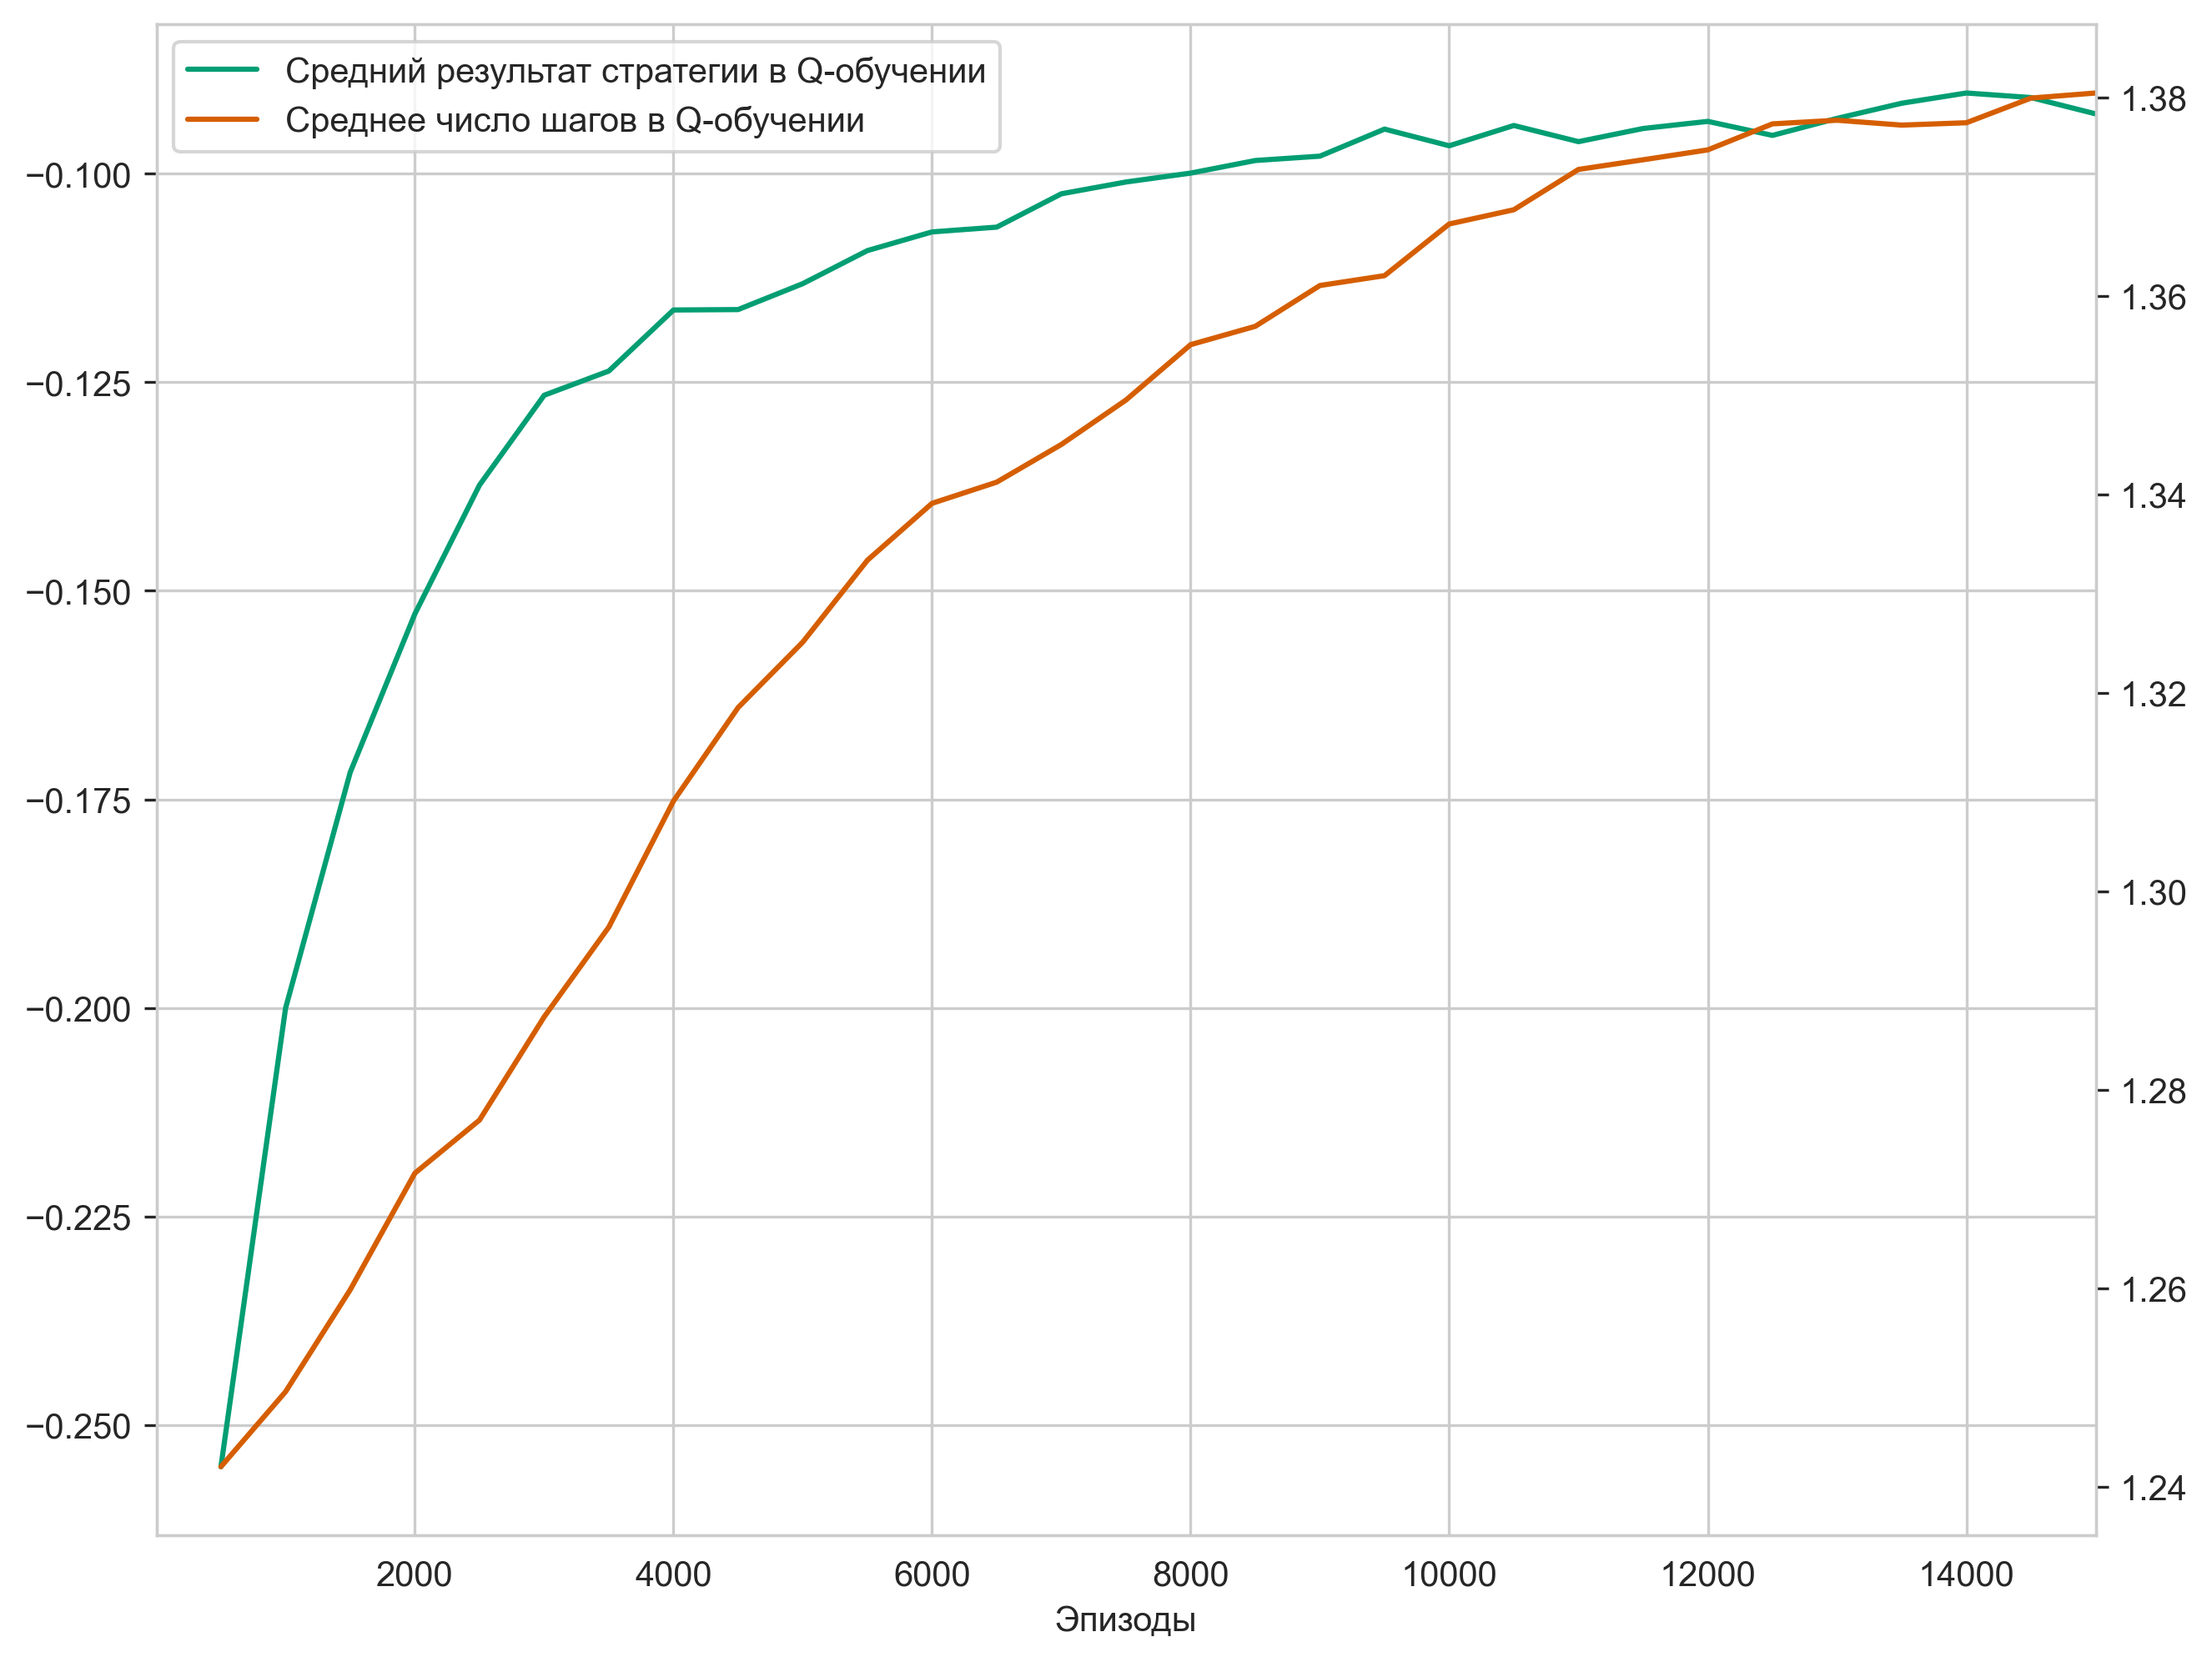

In [43]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
ax2 = ax.twinx()
ax2.grid(None)

avg_returns_Q = np.mean( np.array([ [x[0] for x in res] for res in results_Qlearn]), axis=1)
avg_steps_Q = np.mean( np.array([ [x[1] for x in res] for res in results_Qlearn]), axis=1)

line1 = ax.plot(k, avg_returns_Q, label="Средний результат стратегии в Q-обучении", color="C2")
line2 = ax2.plot(k, avg_steps_Q, label="Среднее число шагов в Q-обучении", color="C3")

lines = line1 + line2
labels = [l.get_label() for l in lines]
ax.legend(lines, labels, loc="upper left")
# ax.set_xlim((0.5, 1.0))
ax.set_xlim((1, total_episodes))
ax.set_xlabel("Эпизоды")

При подборе alpha, epsilon, gamma так и не удалось существенно улучшить результат, он оставался в пределах от -0.06 до -0.08.